# **Book Recommendation System — Collaborative Filtering & Content-Based Approaches**

**Author:** Milos Saric [https://saricmilos.com/]  
**Date:** November 04, 2025 - November 18th, 2025 
**Dataset:** Kaggle — *Book Recommendation Dataset*  
[https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data)

---

This notebook explores the Kaggle Book Recommendation dataset to build intelligent book recommendation systems using both **collaborative filtering** and **content-based** techniques.  
The analysis will guide you through the complete data science workflow, including:

1. **Problem Definition** – Define the recommendation goal: predicting user preferences and suggesting books they are most likely to enjoy. Establish appropriate evaluation metrics (Precision@K, Recall@K, RMSE for ratings prediction, etc.).  

2. **Data Collection & Overview** – Load and inspect datasets including `Books`, `Users`, and `Ratings` from Kaggle. Understand data structure, relationships, and key features (book titles, authors, isbns, user demographics).  

3. **Exploratory Data Analysis (EDA)** – Analyze rating distributions, user activity, popular books, and correlations between users and items. Visualize key insights through plots.

4. **Data Preprocessing & Feature Engineering** – Clean and merge datasets, handle missing values, normalize user IDs, and extract relevant metadata (genres, publication years, etc.).  

5. **Model Development** –  
   - **Collaborative Filtering:** User-based and item-based similarity models using cosine or Pearson correlation.  
   - **Matrix Factorization:** SVD, NMF, or ALS to learn latent user–item representations.  
   - **Content-Based Filtering:** Use TF-IDF or embeddings on book metadata (titles, authors, or summaries) to find similar books.  
   - **Hybrid Models:** Combine collaborative and content-based signals for improved personalization.  

6. **Evaluation & Testing** – Evaluate recommendation quality using cross-validation and ranking-based metrics. Compare different approaches and interpret the top recommended books for sample users.  

7. **Deployment & Future Work** – Outline strategies to deploy the recommendation engine (via Flask/FastAPI) and improve it with deep learning, contextual data, or reinforcement learning.

---

**Objective:**  
To develop a personalized **book recommendation system** capable of understanding user preferences and providing meaningful, data-driven suggestions by integrating collaborative and content-based approaches.

# **About Recommender Systems**

Over the past few decades, platforms like YouTube, Amazon, and Netflix have made recommender systems an essential part of our online experience. Whether it’s suggesting movies to watch, products to buy, or articles to read, these systems help users discover content that matches their interests.

In simple terms, a recommender system is an algorithm that predicts what a user might like based on their preferences and behavior. They play a key role in many industries, not only improving user experience but also driving significant revenue and helping companies stand out from the competition.

---

## **1. Problem Definition**

The first step is to establish a clear understanding of the challenge we aim to solve. This phase lays the groundwork for the entire project and ensures all subsequent efforts remain aligned with the primary objective.

### **Objective**
Develop a **book recommendation system** that predicts and suggests books users are most likely to enjoy, based on their past interactions, ratings, and preferences.  
The system should intelligently recommend books by leveraging techniques such as **collaborative filtering**, **content-based filtering**, or a **hybrid approach**.

### **Scope**
The analysis focuses on the Kaggle *Book Recommendation Dataset*, which includes three key components:  
- **Users** – demographic and identification information.  
- **Books** – metadata such as titles, authors, and publication details.  
- **Ratings** – explicit user feedback (ratings from 1–10).  

Predictions and recommendations are restricted to the dataset provided, without external sources (e.g., Goodreads API or user reviews) unless explicitly integrated in advanced phases.

### **Stakeholders**
- **Readers / Users:** Receive personalized book suggestions based on reading habits and preferences.  
- **publishers & Authors:** Gain insights into reader interests, helping target audiences more effectively.  
- **Data Scientists / ML Practitioners:** Experiment with various recommendation algorithms and performance optimization.  
- **Platform Developers / Businesses:** Improve user engagement, sales, retention, and satisfaction through smarter recommendations.  

### **Success Criteria**
Achieve **high-quality and personalized recommendations**, evaluated using metrics such as:  
- **Precision@K** and **Recall@K** — to measure recommendation relevance.  
- **RMSE / MAE** — for explicit rating prediction accuracy.  
- **User Satisfaction / Engagement Rate** — qualitative indicators of recommendation effectiveness.  

A successful model will deliver **relevant, diverse, and accurate book suggestions** that enhance user experience and foster long-term engagement.

> A clearly defined problem sets the foundation for building a meaningful and effective recommendation system.

## **2. Data Collection**

The **Data Collection** phase focuses on gathering and preparing the datasets required to build and evaluate the book recommendation models. This step also involves importing essential libraries, setting up the working environment, and organizing reusable functions to ensure a smooth analysis workflow.

For this project, the dataset provides detailed information about books, users, and their ratings — forming the foundation for building both **collaborative** and **content-based** recommender systems.

## **Dataset Description**

The **Book-Crossing Dataset** comprises three main files: **Users**, **Books**, and **Ratings**.  
Each file contains essential information used to build and evaluate the book recommendation system.

---

### **1. Users**

Contains user-related information.  
- **user_id** — Anonymized unique identifier for each user (mapped to integers).  
- **location** — User’s location information (typically “City, State, Country”).  
- **age** — User’s age (if available).  

> Note: Some demographic fields may contain `NULL` values if data was unavailable.

---

### **2. Books**

Contains metadata for each book.  
- **isbn** — Unique book identifier (invalid isbns have already been removed).  
- **book_title** — Title of the book.  
- **book_author** — Author name (only the first author is provided in multi-author cases).  
- **year_of_publication** — Year the book was published.  
- **publisher** — Publishing company.  
- **image_url_s / M / L** — URLs linking to small, medium, and large cover images hosted on Amazon.

> Content-based features such as book titles, authors, and publication years were obtained from **Amazon Web Services**.  

---

### **3. Ratings**

Contains user–book interaction data.  
- **user_id** — References a unique user.  
- **isbn** — References a unique book.  
- **book_rating** — Explicit or implicit feedback:  
  - **1–10** → Explicit ratings (higher values indicate stronger preference).  
  - **0** → Implicit feedback (user has interacted but not rated explicitly).

---

You can access the dataset through the following sources:

- **1.** Download directly from the Github repository: [https://github.com/saricmilos/what-else-should-I-read/tree/main/datasets](https://github.com/saricmilos/what-else-should-I-read/tree/main/datasets)  
- **2.** Download from Kaggle: [Book Recommendation Dataset — Kaggle](https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset/data)  

Both sources provide the same data, so you can use whichever is most convenient for your workflow.

> This dataset serves as the backbone of the recommendation system, enabling the discovery of patterns between users and books, and supporting the development of intelligent, personalized recommendation algorithms.

### **Starter Kernel(s)**

This dataset serves as the foundation for building both **collaborative filtering** and **content-based** recommendation models.  
You can begin by:
1. Loading each dataset (`Users`, `Books`, `Ratings`) individually.  
2. Performing exploratory data analysis (EDA) to understand distributions and missing values.  
3. Merging the datasets to form a unified view of user–book interactions.  
4. Building and evaluating different recommendation approaches. 

### Required Libraries Import

In [1]:
%load_ext autoreload
%autoreload 2

# Modules
from src.dataloader import load_all_csvs_from_folder
from src.preprocess_location import preprocess_location
from src.missing_values import (
    missing_values_heatmap,
    missing_values_barchart,
    get_missing_value_summary
    )
from src.unique_values import (
    get_column_types,
    plot_number_of_unique_values,
    unique_values
    )
from src.plots import (
    plot_top_categories,
    plot_boxplot,
    plot_histogram
    )

In [2]:
# Core
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import MinMaxScaler

### Loading Datasets

In [3]:
dataset_folder = Path(r"C:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\datasets")

In [4]:
datasets = load_all_csvs_from_folder(dataset_folder)

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\dataloader.py:63: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  datasets[csv_file.stem] = pd.read_csv(csv_file, **read_csv_kwargs)


In [5]:
print(f"{datasets.keys()}")

dict_keys(['Books', 'Ratings', 'Users'])


In [6]:
books_df = datasets.get("Books")
ratings_df = datasets.get("Ratings")
users_df = datasets.get("Users")

In [7]:
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [9]:
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
books_df.columns = (
    books_df.columns
    .str.strip()          # Removes leading/trailing spaces
    .str.lower()          # Converts to lowercase
    .str.replace('-', '_')# Replaces dashes with underscores
)

In [11]:
ratings_df.columns = (
    ratings_df.columns
    .str.strip()          # Removes leading/trailing spaces
    .str.lower()          # Converts to lowercase
    .str.replace('-', '_')# Replaces dashes with underscores
)

In [12]:
users_df.columns = (
    users_df.columns
    .str.strip()          # Removes leading/trailing spaces
    .str.lower()          # Converts to lowercase
    .str.replace('-', '_')# Replaces dashes with underscores
)

# Initial Feature Engineering

In [13]:
original_users_df = users_df

In [14]:
original_books_df = books_df

In [15]:
original_ratings_df = ratings_df

In [16]:
country_mapping = {
    # USA variants
    'usa': 'usa', 'u.s.a.': 'usa', 'us': 'usa', 'america': 'usa', 'u.s.a': 'usa',
    'united states': 'usa', 'united states of america': 'usa', 'united state': 'usa', 
    'united statea': 'usa', 'u.s. of a.': 'usa', 'u.s>': 'usa', 'uusa': 'usa',
    'usa now': 'usa', 'good old usa !': 'usa', 'good old u.s.a.': 'usa',
    'usa (currently living in england)': 'usa', 'usa"': 'usa', 'us virgin islands': 'usa',
    'american samoa': 'usa', 'ca': 'usa', 'nyc': 'usa', 'fl': 'usa', 'tx': 'usa',
    'arizona': 'usa', 'california': 'usa', 'new york': 'usa', 'massachusetts': 'usa',
    'ohio': 'usa', 'colorado': 'usa', 'michigan': 'usa', 'virginia': 'usa',
    'washington': 'usa', 'missouri': 'usa', 'pennsylvania': 'usa', 'illinois': 'usa',
    'nevada': 'usa', 'florida': 'usa', 'north carolina': 'usa', 'south carolina': 'usa',
    'west virginia': 'usa', 'maine': 'usa', 'minnesota': 'usa', 'montana': 'usa',
    'new jersey': 'usa', 'hawaii': 'usa', 'alaska': 'usa', 'texas': 'usa',
    'louisiana': 'usa', 'oh': 'usa', 'nj': 'usa', 'ny': 'usa', 'va': 'usa',
    'pa': 'usa', 'arizona': 'usa', 'florida': 'usa', 'mi': 'usa', 'california': 'usa',
    'anystate': 'usa', 'everywhere and anywhere': 'usa', 'land of the free': 'usa',
    
    # UK variants
    'uk': 'united kingdom', 'u.k.': 'united kingdom', 'england': 'united kingdom',
    'england uk': 'united kingdom', 'united kingdom': 'united kingdom', 'scotland': 'united kingdom',
    'wales': 'united kingdom', 'northern ireland': 'united kingdom',
    
    # Germany variants
    'germany': 'germany', 'deutschland': 'germany', 'germay': 'germany', 'deutsches reich': 'germany',
    'baden-wuerttemberg': 'germany', 'baden-württemberg': 'germany', 'hessen': 'germany',
    'rheinland-pfalz': 'germany', 'bayern': 'germany', 'berlin': 'germany',
    
    # Spain variants
    'spain': 'spain', 'españa': 'spain', 'espana': 'spain', 'espã±a': 'spain', 
    'spain"': 'spain', 'andalucia': 'spain', 'catalunya': 'spain', 'catalonia': 'spain',
    'pais vasco': 'spain', 'valtesse': 'spain', 'laos': 'spain', 'aragon': 'spain',
    
    # Italy variants
    'italy': 'italy', 'italia': 'italy', 'l`italia': 'italy', 'italien': 'italy',
    'italy"': 'italy', 'emilia romagna': 'italy', 'lazio': 'italy', 'sicilia': 'italy',
    'veneto': 'italy', 'toscana': 'italy', 'piemonte': 'italy', 'roma': 'italy', 'milano': 'italy',
    'prov. di milano': 'italy', 'trentino alto adige': 'italy', 'roma': 'italy',
    
    # France variants
    'france': 'france', 'la france': 'france', 'france"': 'france', 'ile de france': 'france',
    'bourgogne': 'france', 'alsace': 'france',
    
    # Portugal variants
    'portugal': 'portugal', 'portugal"': 'portugal', 'alentejo': 'portugal',
    'lisboa': 'portugal', 'porto': 'portugal', 'coimbra': 'portugal', 'azores': 'portugal',
    
    # China variants
    'china': 'china', 'p.r.china': 'china', 'p.r. china': 'china', 'people`s republic of china': 'china',
    'china people`s republic': 'china', 'cn': 'china', 'china"': 'china', 'beijing': 'china',
    'shanghai': 'china', 'liaoning': 'china', 'shanxi province': 'china', 'hubei province': 'china',
    'hunan': 'china', 'guangdong': 'china', 'shandong province': 'china', 'hebei': 'china',
    
    # Australia variants
    'australia': 'australia', 'autralia': 'australia', 'australii': 'australia',
    'australian capital territory': 'australia', 'new south wales': 'australia', 'nsw': 'australia',
    'victoria': 'australia', 'queensland': 'australia', 'western australia': 'australia',
    'south australia': 'australia', 'tasmania': 'australia', 'canberra': 'australia',
    
    # India variants
    'india': 'india', 'india"': 'india', 'maharashtra': 'india', 'maharastra': 'india',
    'jharkhand': 'india', 'punjab': 'india', 'tamil nadu': 'india', 'indiai': 'india',
    
    # Japan variants
    'japan': 'japan', 'japan military': 'japan', 'japan"': 'japan', 'tokyo': 'japan',
    'osaka': 'japan', 'seoul korea': 'japan', 'shizuoka pref.': 'japan',
    
    # Misc / Other countries (examples)
    'canada': 'canada', 'british columbia': 'canada', 'ontario': 'canada', 'newfoundland': 'canada',
    'mexico': 'mexico', 'mexico"': 'mexico', 'ciudad de mexico': 'mexico', 'nuevo leon': 'mexico',
    'venezuela': 'venezuela', 'venezuela"': 'venezuela', 'brazil': 'brazil', 'brasil': 'brazil',
    'brazil"': 'brazil', 'argentina': 'argentina', 'la argentina': 'argentina', 'argentina"': 'argentina',
    'germany"': 'germany', 'deutschland"': 'germany', 'spain"': 'spain',
    'south korea': 'south korea', 'south korea"': 'south korea', 'korea': 'south korea', 's.corea': 'south korea',
    
    # Catch all N/A or unknown
    'n/a': 'unknown', 'n/a"': 'unknown', 'none': 'unknown', 'unknown': 'unknown', '"': 'unknown', '-': 'unknown',
    '.': 'unknown', '*': 'unknown',
}

In [17]:
region_mapping = {
    # North America
    'usa': 'North America',
    'canada': 'North America',
    'mexico': 'North America',
    'bahamas': 'North America',
    'puerto rico': 'North America',
    'bermuda': 'North America',
    'dc': 'North America',
    'oregon': 'North America',  # US state
    'u.s.a': 'North America',
    
    # Central America & Caribbean
    'costa rica': 'Central America',
    'panama': 'Central America',
    'guatemala': 'Central America',
    'jamaica': 'Caribbean',
    'trinidad and tobago': 'Caribbean',
    'dominican republic': 'Caribbean',
    'grenada': 'Caribbean',
    'barbados': 'Caribbean',
    
    # South America
    'brazil': 'South America',
    'argentina': 'South America',
    'chile': 'South America',
    'colombia': 'South America',
    'peru': 'South America',
    'venezuela': 'South America',
    'bolivia': 'South America',
    'uruguay': 'South America',
    'ecuador': 'South America',
    'paraguay': 'South America',
    'urugua': 'South America',  # typo
    
    # Europe
    'united kingdom': 'Europe',
    'germany': 'Europe',
    'spain': 'Europe',
    'italy': 'Europe',
    'france': 'Europe',
    'portugal': 'Europe',
    'netherlands': 'Europe',
    'switzerland': 'Europe',
    'sweden': 'Europe',
    'finland': 'Europe',
    'belgium': 'Europe',
    'ireland': 'Europe',
    'poland': 'Europe',
    'greece': 'Europe',
    'romania': 'Europe',
    'croatia': 'Europe',
    'slovakia': 'Europe',
    'czech republic': 'Europe',
    'russia': 'Europe/Asia',
    'yugoslavia': 'Europe',
    'slovenia': 'Europe',
    'luxembourg': 'Europe',
    'hungary': 'Europe',
    'iceland': 'Europe',
    'andorra': 'Europe',
    'ukraine': 'Europe',
    'lithuania': 'Europe',
    'latvia': 'Europe',
    'malta': 'Europe',
    'albania': 'Europe',
    'macedonia': 'Europe',
    'cyprus': 'Europe',
    'belarus': 'Europe',
    'estonia': 'Europe',
    'austria': 'Europe',
    'austria"': 'Europe',  # in case of trailing quotes
    
    # Asia
    'china': 'Asia',
    'japan': 'Asia',
    'south korea': 'Asia',
    'taiwan': 'Asia',
    'hong kong': 'Asia',
    'india': 'Asia',
    'malaysia': 'Asia',
    'singapore': 'Asia',
    'philippines': 'Asia',
    'indonesia': 'Asia',
    'pakistan': 'Asia',
    'iran': 'Asia',
    'thailand': 'Asia',
    'vietnam': 'Asia',
    'nepal': 'Asia',
    'kazakhstan': 'Asia',
    'afghanistan': 'Asia',
    'brunei': 'Asia',
    'u.a.e': 'Middle East',
    'united arab emirates': 'Middle East',
    'qatar': 'Middle East',
    'kuwait': 'Middle East',
    'bahrain': 'Middle East',
    'oman': 'Middle East',
    'iraq': 'Middle East',
    'sri lanka': 'Asia',
    'burma': 'Asia',
    
    # Africa
    'south africa': 'Africa',
    'ghana': 'Africa',
    'egypt': 'Africa',
    'algeria': 'Africa',
    'kenya': 'Africa',
    'zimbabwe': 'Africa',
    'ethiopia': 'Africa',
    'mozambique': 'Africa',
    'benin': 'Africa',
    'morocco': 'Africa',
    'mauritius': 'Africa',
    
    # Oceania
    'australia': 'Oceania',
    'new zealand': 'Oceania',
    'fiji': 'Oceania',
    
    # Other / Unknown / Misc
    'unknown': 'Unknown',
    'other': 'Unknown',
    'antarctica': 'Other',
    'east africa': 'Africa',
    'caribbean sea': 'Other',
    'euskal herria': 'Europe',  # Basque Country (Spain/France)
}


In [18]:
users_df.head()

,user_id,location,age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [19]:
users_df = preprocess_location(users_df,country_mapping=country_mapping,region_mapping=region_mapping,top_cities= 50,top_states= 50)

Common situation with user-entered location data: lots of typos, alternate spellings, subregions, and single-entry “countries.” simplify and group rare/ambiguous values.

In [20]:
users_df.head()

,user_id,location,age,country_clean,region,city_clean,state_clean
0,1,"nyc, new york, usa",NaN,usa,North America,other,new york
1,2,"stockton, california, usa",18.0,usa,North America,other,california
2,3,"moscow, yukon territory, russia",NaN,russia,Europe/Asia,other,other
3,4,"porto, v.n.gaia, portugal",17.0,portugal,Europe,other,other
4,5,"farnborough, hants, united kingdom",NaN,united kingdom,Europe,other,other


In [21]:
users_df = users_df.drop(columns="location")

##  **3. Exploratory Data Analysis (EDA)**

Exploratory Data Analysis is all about **understanding the dataset**, uncovering patterns, spotting anomalies, and generating insights that will guide feature engineering and modeling.

## 3.1. Datasets Basic Information

### 3.1.1. Books Dataset

In [22]:
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [23]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271360 non-null  object
 1   book_title           271360 non-null  object
 2   book_author          271358 non-null  object
 3   year_of_publication  271360 non-null  object
 4   publisher            271358 non-null  object
 5   image_url_s          271360 non-null  object
 6   image_url_m          271360 non-null  object
 7   image_url_l          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [24]:
books_df.describe()

,isbn,book_title,book_author,year_of_publication,publisher,image_url_s,image_url_m,image_url_l
count,271360,271360,271358,271360,271358,271360,271360,271357
unique,271360,242135,102022,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/155936078X.0...,http://images.amazon.com/images/P/155936078X.0...,http://images.amazon.com/images/P/155936078X.0...
freq,1,27,632,13903,7535,2,2,2


In [25]:
books_df = books_df.drop(columns= ["image_url_s","image_url_m","image_url_l"])

In [26]:
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


### 3.1.2. Ratings Dataset

In [27]:
ratings_df.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [28]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149780 non-null  int64 
 1   isbn         1149780 non-null  object
 2   book_rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Number of non-null entries (≈1,149,780 rows).
mean	The average value. For user_id, it’s meaningless — IDs aren’t numeric data, just identifiers. For book_rating, the mean is 2.87, which means the average book rating across all users is around 2.87 out of 10.
std	Standard deviation (spread). A higher std means more variation. Ratings vary a lot (≈3.85).
min	The minimum value. book_rating has a minimum of 0, meaning some users gave 0 ratings.
25% (Q1)	25% of ratings are below 0.
50% (Median)	50% of ratings are 0, meaning half of all ratings are “no rating” (or implicit 0s).
75% (Q3)	75% of ratings are below 7.
max	The maximum rating is 10. This shows a sparse ratings matrix — most users haven’t rated many books, and many ratings are zero (unrated).
That’s typical in recommendation datasets.

In [29]:
ratings_df.describe()

,user_id,book_rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


### 3.1.3. Users Dataset

In [30]:
users_df.head()

,user_id,age,country_clean,region,city_clean,state_clean
0,1,NaN,usa,North America,other,new york
1,2,18.0,usa,North America,other,california
2,3,NaN,russia,Europe/Asia,other,other
3,4,17.0,portugal,Europe,other,other
4,5,NaN,united kingdom,Europe,other,other


In [31]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        278858 non-null  int64  
 1   age            168096 non-null  float64
 2   country_clean  278858 non-null  object 
 3   region         278858 non-null  object 
 4   city_clean     278858 non-null  object 
 5   state_clean    278858 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 12.8+ MB


Maximum age is 244.000000, meaning there are outliers to be adressed

count	278,858	168,096	Total non-null entries. So, about 110k users have no age recorded.
mean	139,429.5	34.75	Average user ID (not meaningful), average age ≈ 35 years.
std	80,499.5	14.43	IDs are spread uniformly (fine), age varies with std ≈ 14 years.
min	1	0	Someone’s age is 0 — likely a missing or invalid entry.
25%	69,715	24	25% of users are younger than 24.
50% (median)	139,429	32	The typical user is 32 years old.
75%	209,143	44	75% are younger than 44.
max	278,858	244	There’s an outlier age = 244, definitely an invalid entry.

In [32]:
users_df.describe()

,user_id,age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


In [33]:
shapes = pd.DataFrame({
    "Dataset": ["books_df", "ratings_df","users_df"],
    "Shape": [books_df.shape, ratings_df.shape,users_df.shape]
})
print(shapes.to_string(index=False))

   Dataset        Shape
  books_df  (271360, 5)
ratings_df (1149780, 3)
  users_df  (278858, 6)


## 3.2. Missing Values

### 3.2.1. Books Dataset

In [34]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            2
year_of_publication    0
publisher              2
dtype: int64

In [35]:
na_counts_books = books_df.isna().sum().reset_index()
na_counts_books.columns = ['Feature', 'MissingValues']

In [36]:
print(f"{na_counts_books}")

               Feature  MissingValues
0                 isbn              0
1           book_title              0
2          book_author              2
3  year_of_publication              0
4            publisher              2


In [37]:
get_missing_value_summary(books_df)

,Column,Dtype,TotalValues,MissingValues,NonMissingValues,MissingPercent
0,isbn,object,271360,0,271360,0.000000
1,book_title,object,271360,0,271360,0.000000
2,book_author,object,271360,2,271358,0.000737
3,year_of_publication,object,271360,0,271360,0.000000
4,publisher,object,271360,2,271358,0.000737


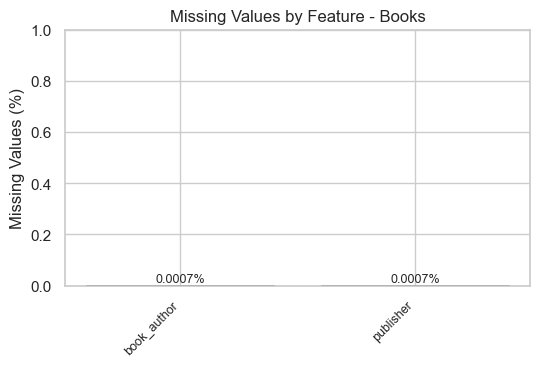

book_author    0.000737
publisher      0.000737
dtype: float64

In [38]:
missing_values_barchart(books_df,"Books")

In [39]:
books_df[books_df['publisher'].isnull()]

,isbn,book_title,book_author,year_of_publication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [40]:
books_df[books_df['book_author'].isnull()]

,isbn,book_title,book_author,year_of_publication,publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


### 3.2.2. Ratings Dataset

In [41]:
ratings_df.isna().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

In [42]:
na_counts_ratings = ratings_df.isna().sum().reset_index()
na_counts_ratings.columns = ['Feature', 'MissingValues']

In [43]:
print(f"{na_counts_ratings}")

       Feature  MissingValues
0      user_id              0
1         isbn              0
2  book_rating              0


In [44]:
get_missing_value_summary(ratings_df)

,Column,Dtype,TotalValues,MissingValues,NonMissingValues,MissingPercent
0,user_id,int64,1149780,0,1149780,0.0
1,isbn,object,1149780,0,1149780,0.0
2,book_rating,int64,1149780,0,1149780,0.0


### 3.2.3. Users Dataset

In [45]:
users_df.isna().sum()

user_id               0
age              110762
country_clean         0
region                0
city_clean            0
state_clean           0
dtype: int64

In [46]:
na_counts_users = users_df.isna().sum().reset_index()
na_counts_users.columns = ['Feature', 'MissingValues']

In [47]:
print(f"{na_counts_users}")

         Feature  MissingValues
0        user_id              0
1            age         110762
2  country_clean              0
3         region              0
4     city_clean              0
5    state_clean              0


In [48]:
get_missing_value_summary(users_df)

,Column,Dtype,TotalValues,MissingValues,NonMissingValues,MissingPercent
0,user_id,int64,278858,0,278858,0.000000
1,age,float64,278858,110762,168096,39.719857
2,country_clean,object,278858,0,278858,0.000000
3,region,object,278858,0,278858,0.000000
4,city_clean,object,278858,0,278858,0.000000
5,state_clean,object,278858,0,278858,0.000000


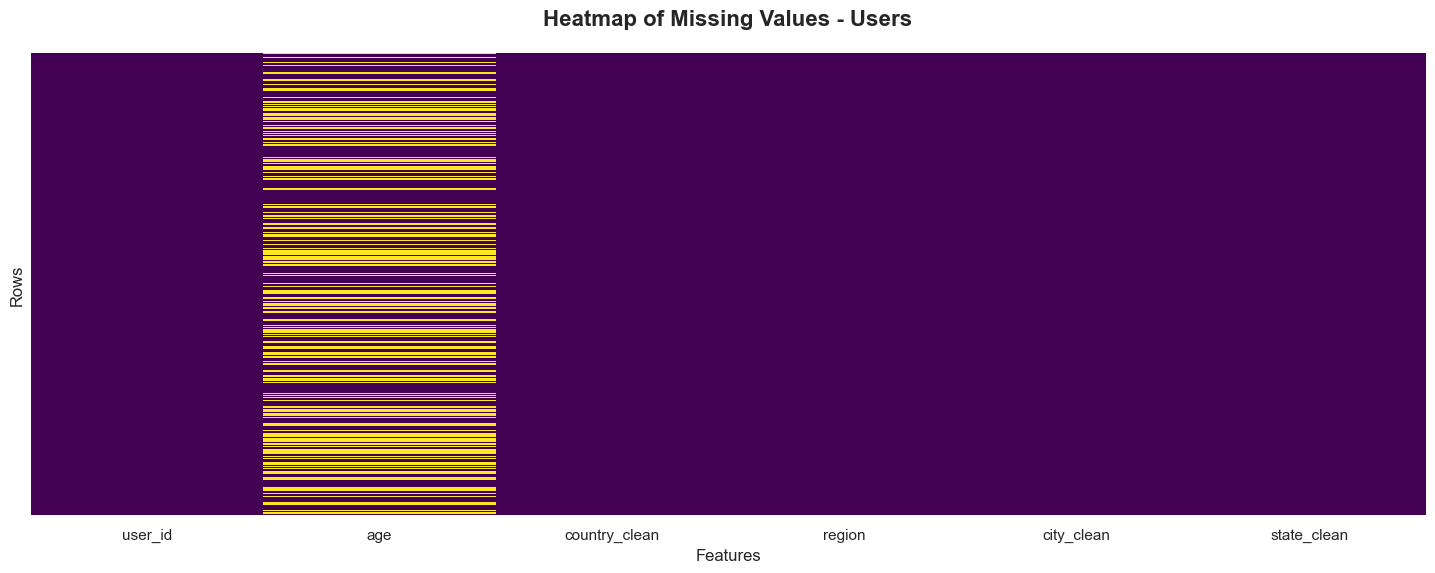

In [49]:
missing_values_heatmap(users_df,"Users")

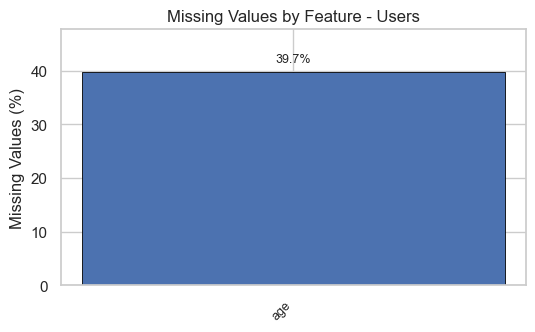

age    39.719857
dtype: float64

In [50]:
missing_values_barchart(users_df,"Users")

In [51]:
users_df[users_df['age'].isnull()]

,user_id,age,country_clean,region,city_clean,state_clean
0,1,NaN,usa,North America,other,new york
2,3,NaN,russia,Europe/Asia,other,other
4,5,NaN,united kingdom,Europe,other,other
6,7,NaN,usa,North America,washington,other
7,8,NaN,canada,North America,other,ontario
...,...,...,...,...,...,...
278849,278850,NaN,italy,Europe,other,lombardia
278853,278854,NaN,usa,North America,portland,oregon
278855,278856,NaN,canada,North America,other,ontario
278856,278857,NaN,usa,North America,other,tennessee


# 3.3. Unique Values

### 3.3.1. Books Dataset

In [52]:
cat_cols_books, int_cols_books, float_cols_books = get_column_types(books_df)

Categorical variables:
['isbn', 'book_title', 'book_author', 'year_of_publication', 'publisher']

Integer variables:
[]

Real (float) variables:
[]


isbn	271,360	271,360	100.00%	Every book has a unique ISBN — great, this is your unique identifier.
book_title	242,135	271,360	89.23%	Most titles are unique, but some duplicates exist (e.g., same book reissued, different editions).
book_author	102,022	271,360	37.60%	There are ~100k unique authors, meaning each author has, on average, about 2–3 books.
publisher	16,807	271,360	6.19%	Only ~6% of entries have unique publishers — consistent with many books from the same publisher.
year_of_publication	202	271,360	0.07%	Only ~200 unique publication years — typical, since years repeat for many books.

In [53]:
unique_values(books_df)

,Column,UniqueValues,TotalValues,UniquePercent
0,isbn,271360,271360,100.00
1,book_title,242135,271360,89.23
2,book_author,102022,271360,37.60
3,publisher,16807,271360,6.19
4,year_of_publication,202,271360,0.07


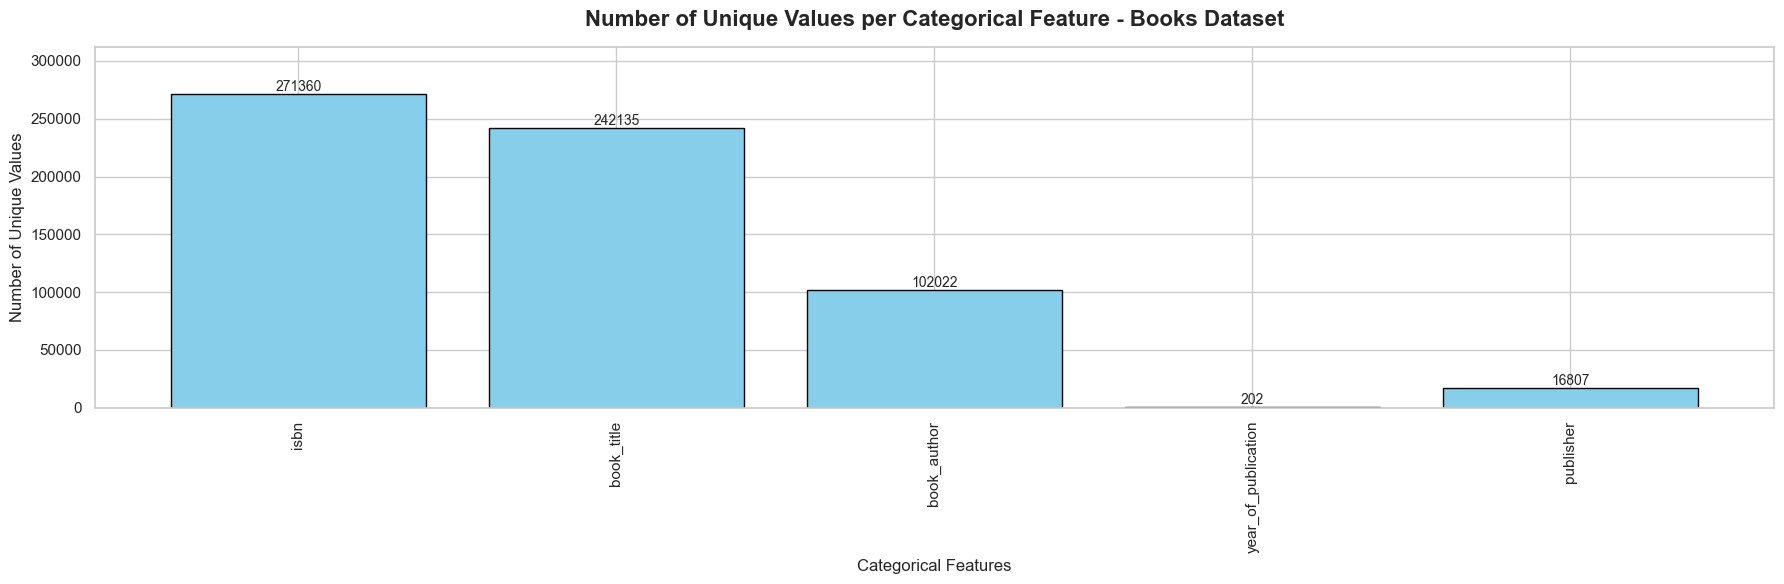

In [54]:
plot_number_of_unique_values(books_df,cat_cols_books,"Books Dataset")

### 3.3.2. Ratings Dataset

In [55]:
cat_cols_ratings, int_cols_ratings, float_cols_ratings = get_column_types(ratings_df)

Categorical variables:
['isbn']

Integer variables:
['user_id', 'book_rating']

Real (float) variables:
[]


In [56]:
unique_values(ratings_df)

,Column,UniqueValues,TotalValues,UniquePercent
0,isbn,340556,1149780,29.62
1,user_id,105283,1149780,9.16
2,book_rating,11,1149780,0.00


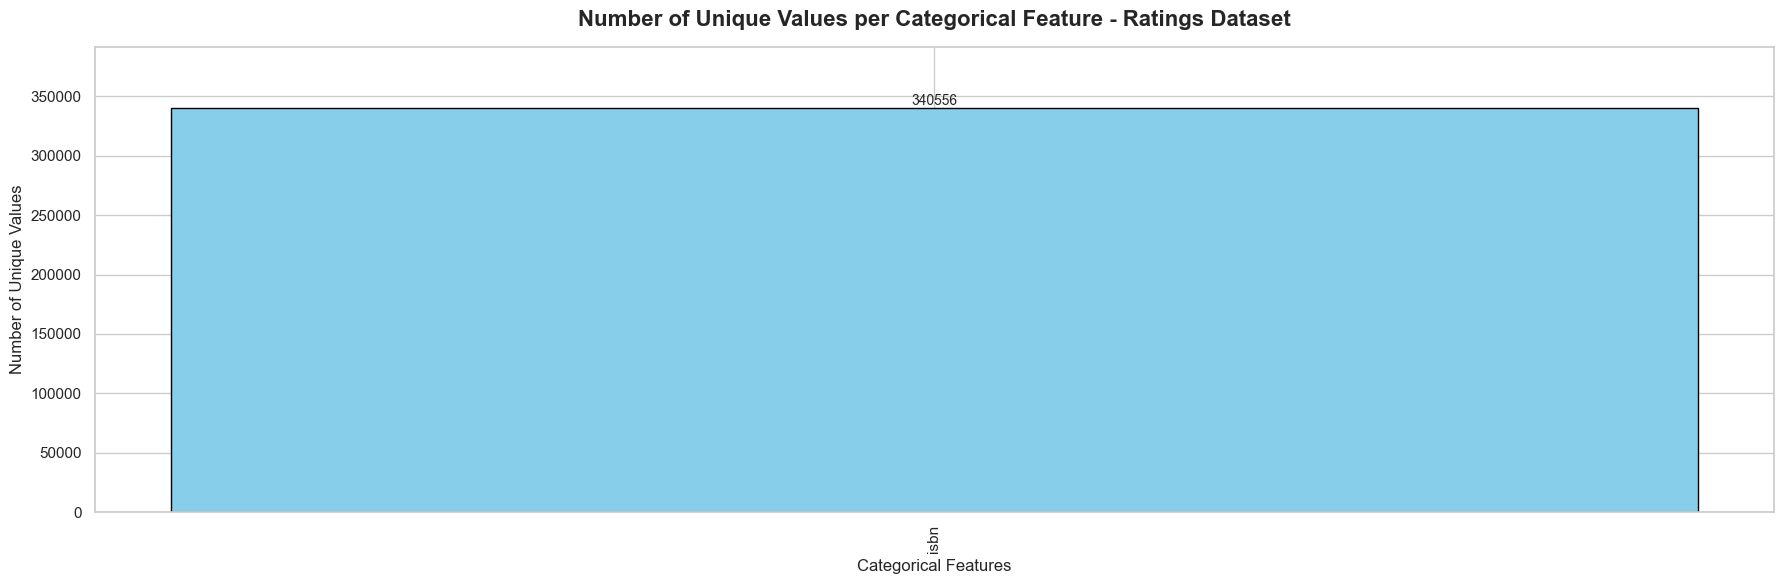

In [57]:
plot_number_of_unique_values(ratings_df,cat_cols_ratings,"Ratings Dataset")

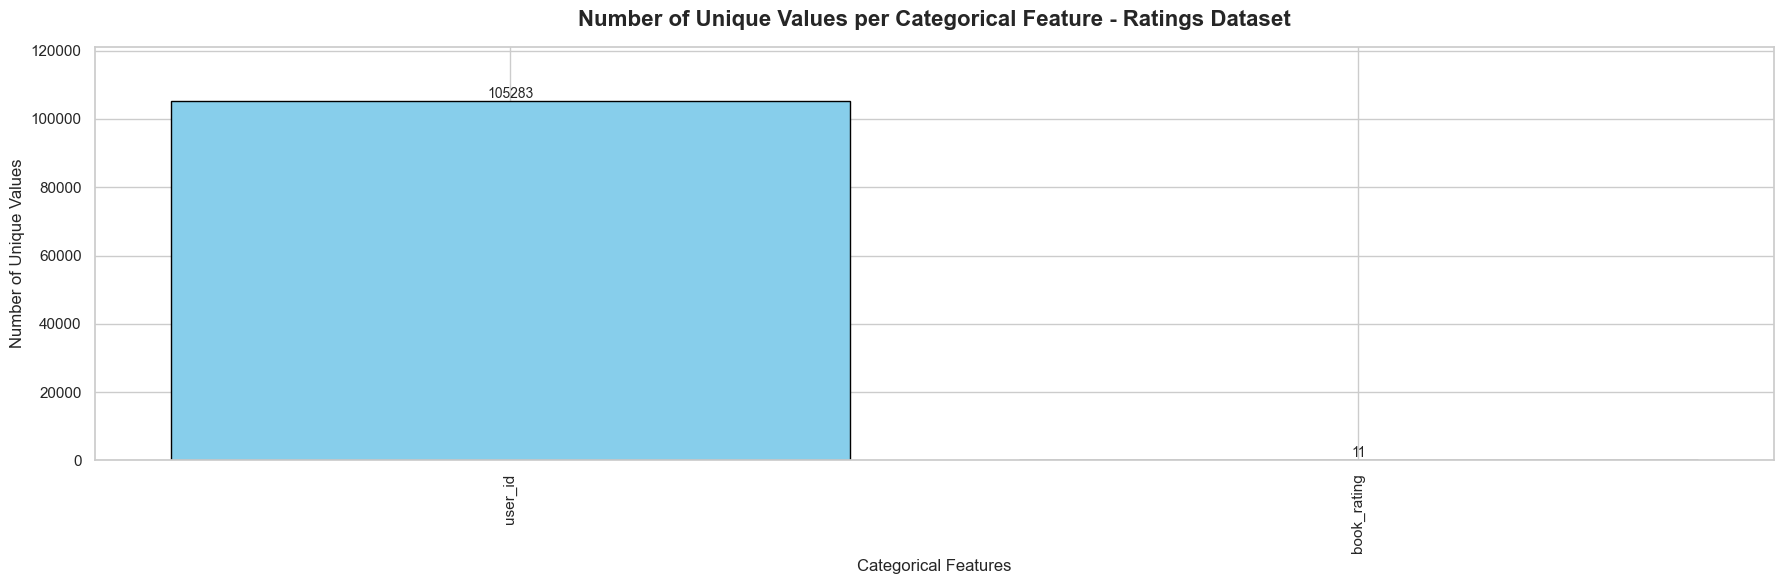

In [58]:
plot_number_of_unique_values(ratings_df,int_cols_ratings,"Ratings Dataset")

### 3.3.3. Users Dataset

In [59]:
cat_cols_users, int_cols_users, float_cols_users = get_column_types(users_df)

Categorical variables:
['country_clean', 'region', 'city_clean', 'state_clean']

Integer variables:
['user_id']

Real (float) variables:
['age']


In [60]:
unique_values(users_df)

,Column,UniqueValues,TotalValues,UniquePercent
0,user_id,278858,278858,100.00
1,age,165,278858,0.06
2,country_clean,131,278858,0.05
3,city_clean,51,278858,0.02
4,state_clean,50,278858,0.02
5,region,13,278858,0.00


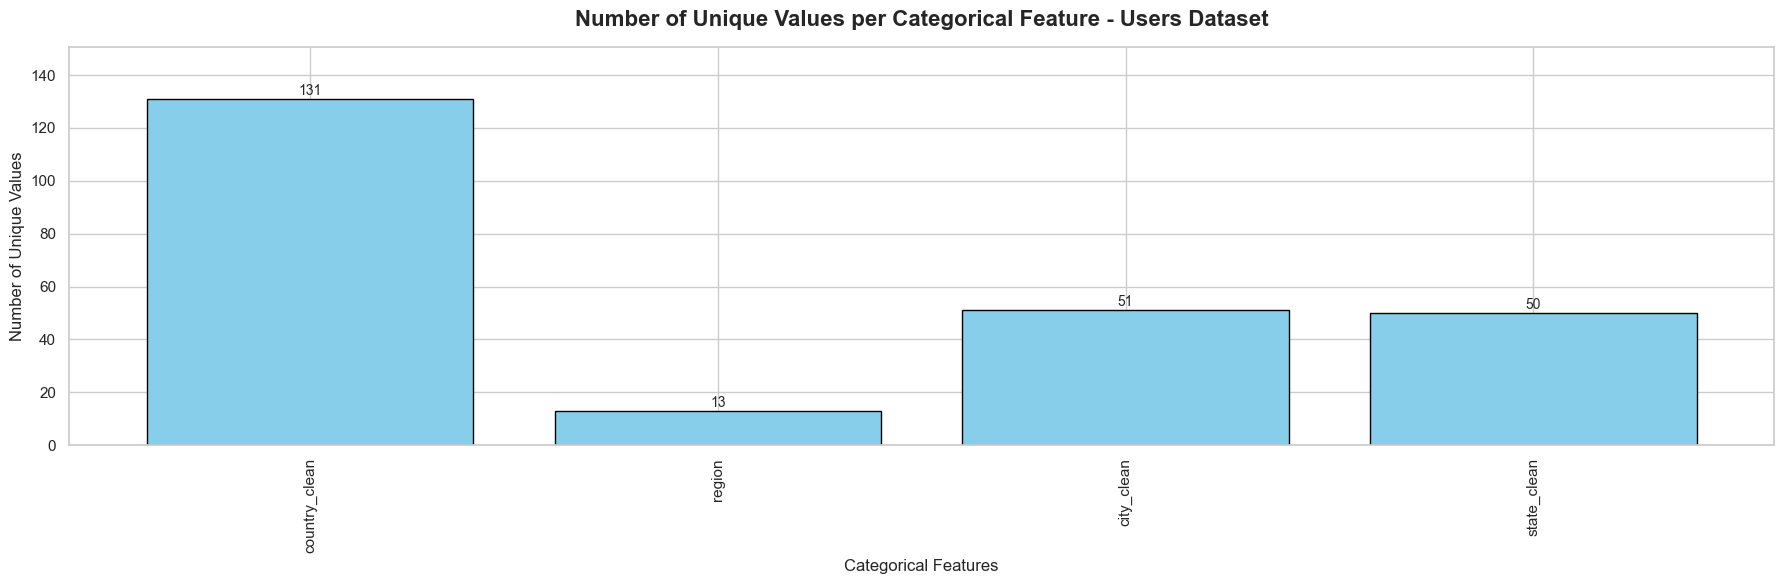

In [61]:
plot_number_of_unique_values(users_df,cat_cols_users,"Users Dataset")

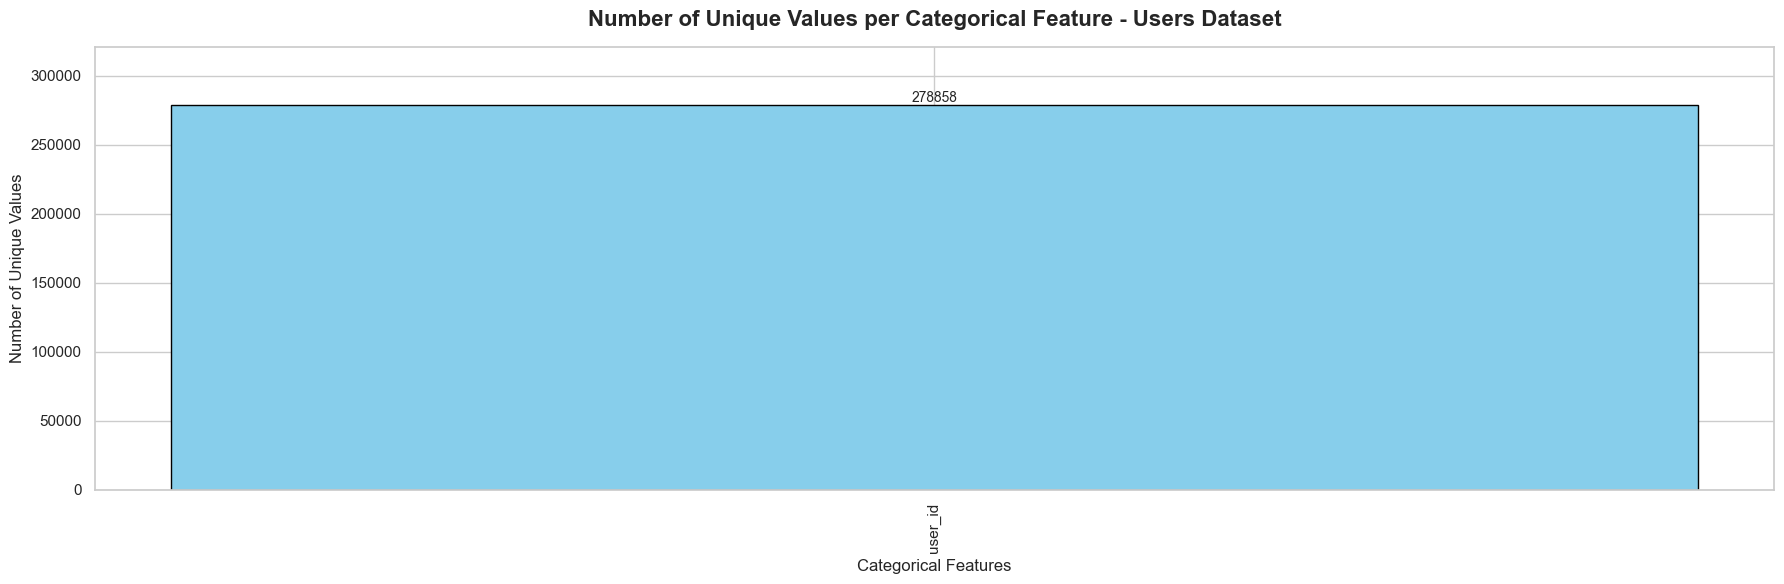

In [62]:
plot_number_of_unique_values(users_df,int_cols_users,"Users Dataset")

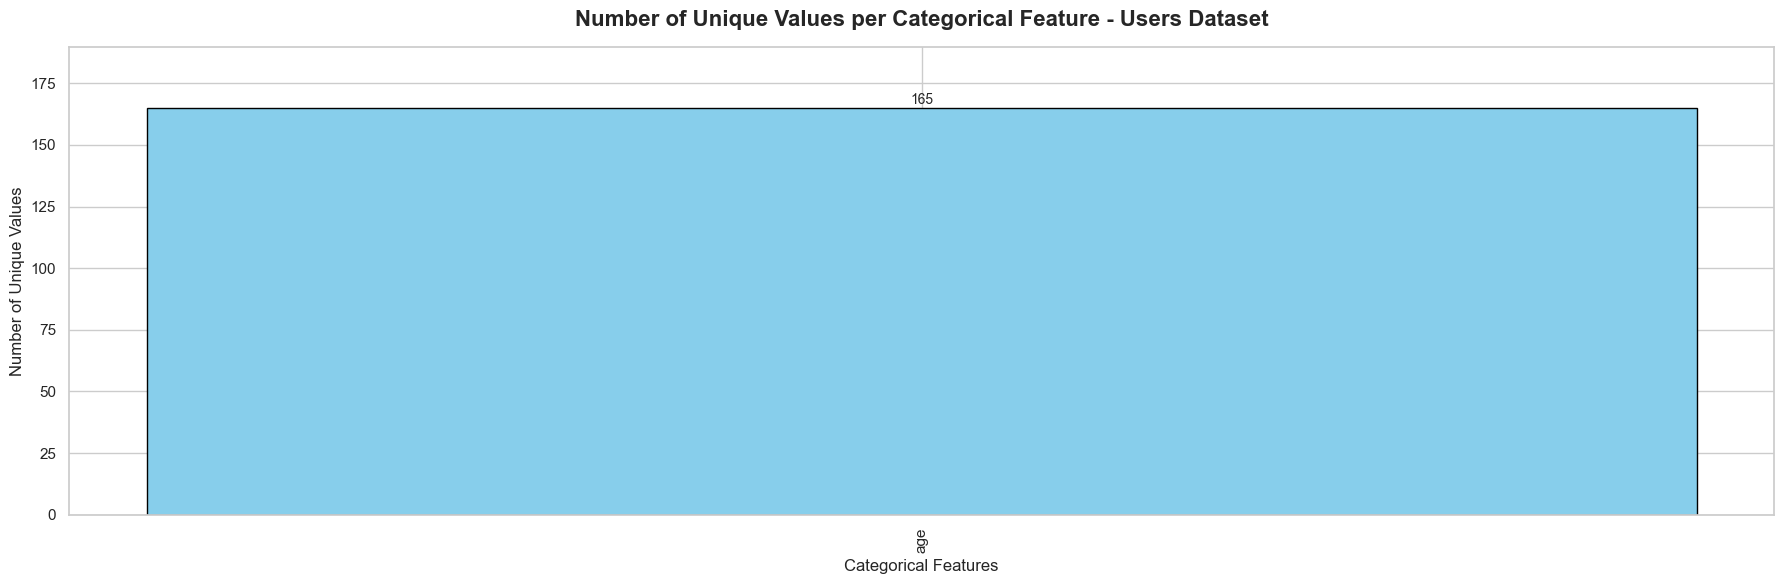

In [63]:
plot_number_of_unique_values(users_df,float_cols_users,"Users Dataset")

# 3.4. Histograms / KDA

### 3.4.1. age

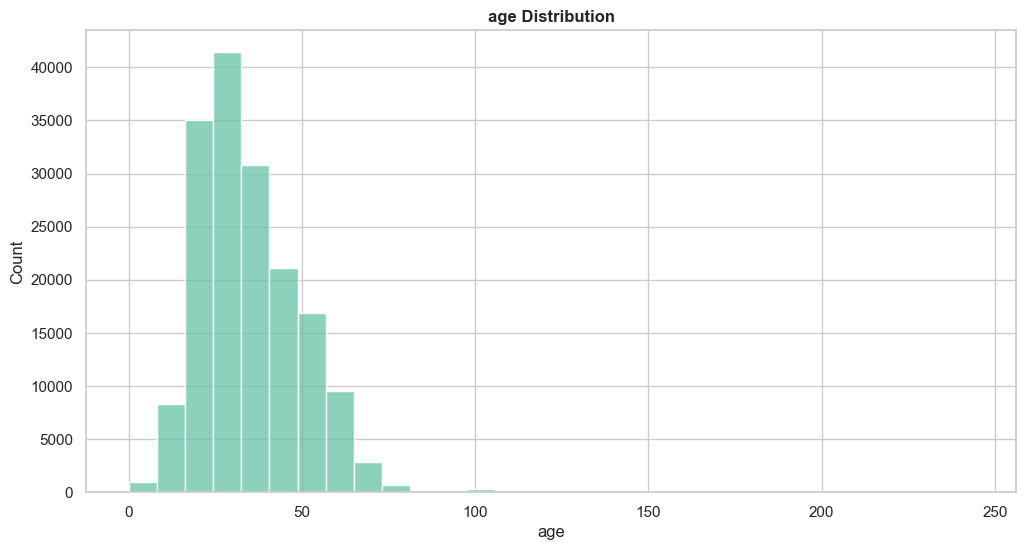

In [64]:
plot_histogram(users_df, 'age', bins=30, title='age Distribution')

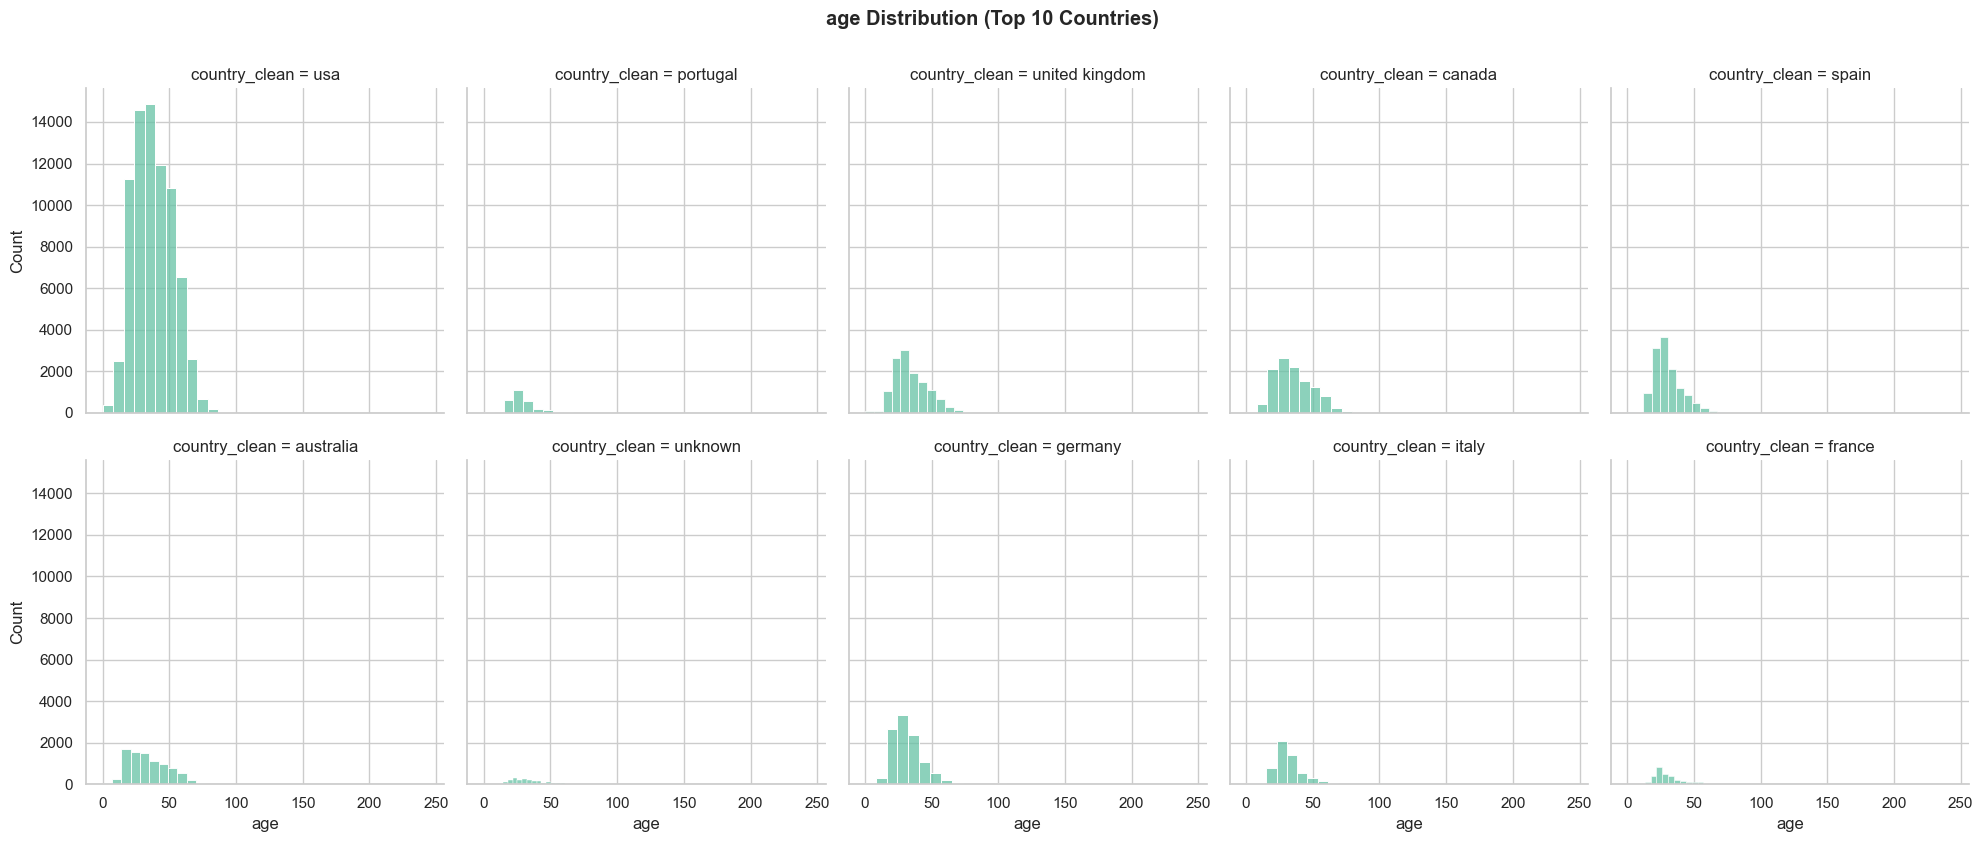

In [65]:
plot_histogram(users_df, 'age', bins=30, title='age Distribution (Top 10 Countries)', by='country_clean', top_n=10)

In [66]:
ratings_df.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# 3.4.2. Book Rating

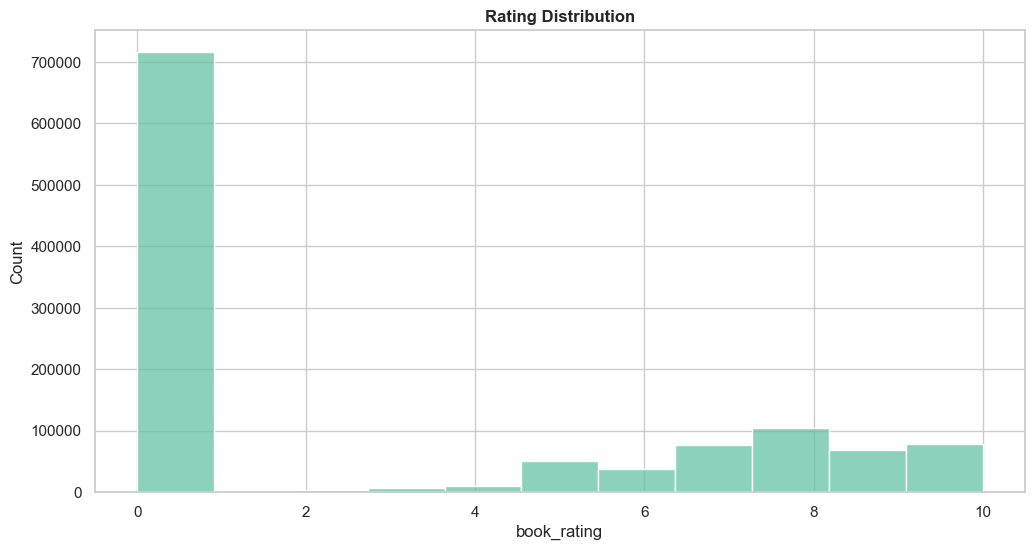

In [67]:
plot_histogram(ratings_df, 'book_rating', bins=11, title='Rating Distribution')

### 3.4.3. Year of Publication

In [68]:
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [69]:
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


# 3.5. Boxplots

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y=column, data=df, palette=palette)


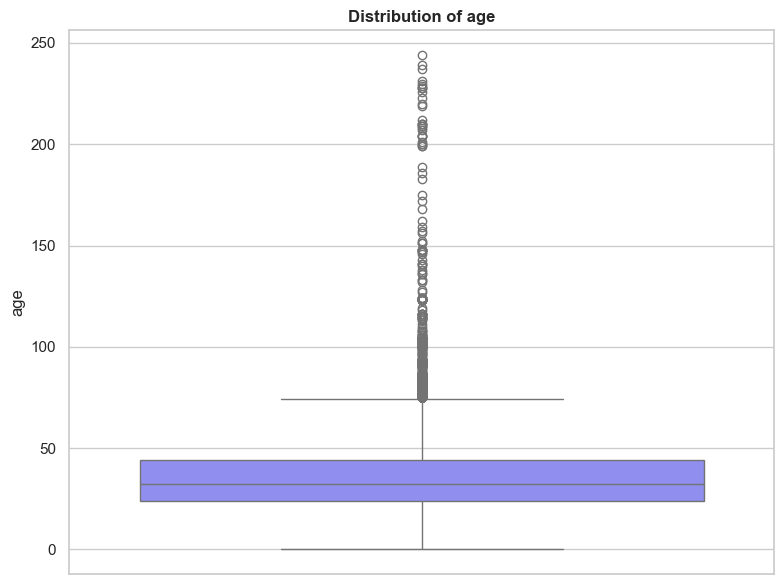

<Axes: title={'center': 'Distribution of age'}, ylabel='age'>

In [70]:
plot_boxplot(users_df, 'age', title='Distribution of age', ylabel='age', palette='cool')

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x=by, y=column, data=df, palette=palette)


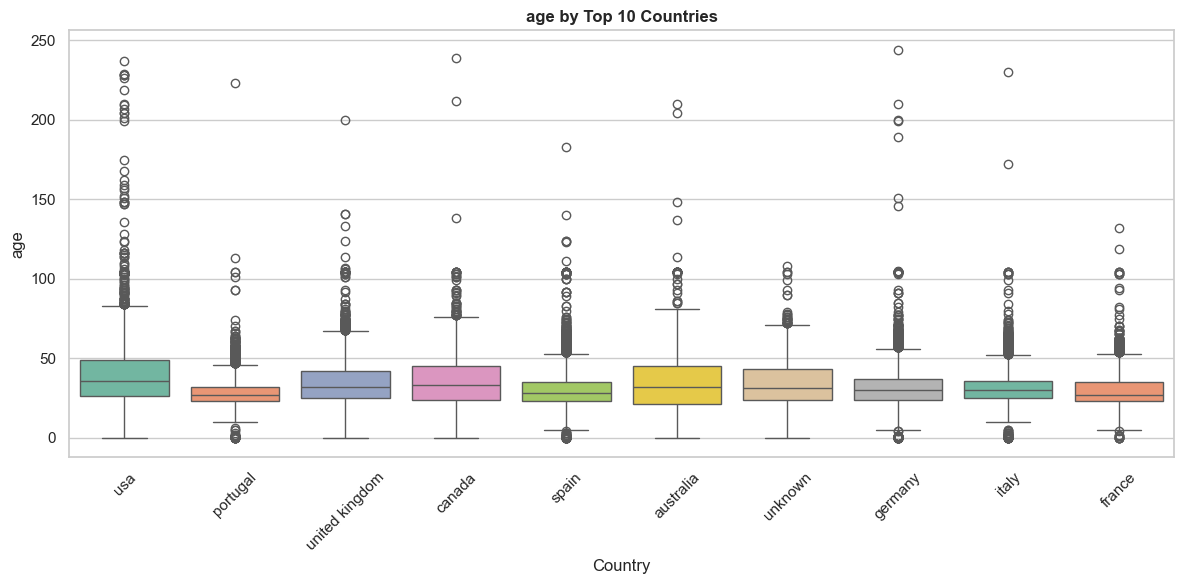

<Axes: title={'center': 'age by Top 10 Countries'}, xlabel='Country', ylabel='age'>

In [71]:
# Get top 10 countries by count
top_countries = users_df['country_clean'].value_counts().nlargest(10).index

# Filter the DataFrame
df_top10 = users_df[users_df['country_clean'].isin(top_countries)]

# Plot only the top 10 countries
plot_boxplot(
    df_top10, 
    column='age', 
    by='country_clean', 
    title='age by Top 10 Countries', 
    ylabel='age', 
    xlabel='Country', 
    palette='Set2', 
    rotate_xticks=True, 
    figsize=(12,6)
)

# 3.6. Other charts

### 3.6.1. Country

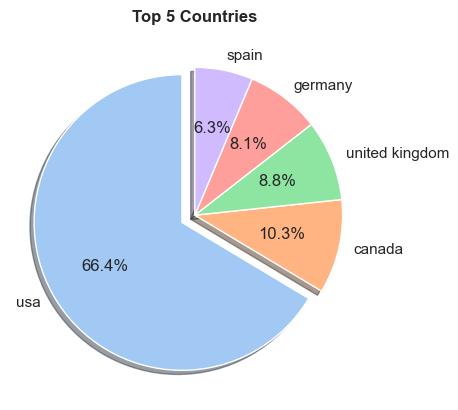

In [72]:
palette_color = sns.color_palette('pastel')
explode = [0.1] + [0]*(min(5, len(users_df['country_clean'].value_counts())) - 1)  # highlight first slice

users_df['country_clean'].value_counts().iloc[:5].plot(
    kind='pie',
    colors=palette_color,
    autopct='%.1f%%',
    explode=explode,
    shadow=True,
    startangle=90
)
plt.title('Top 5 Countries', fontweight='bold')
plt.ylabel('')
plt.show()

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\3364717479.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='country_clean', data=users_df,


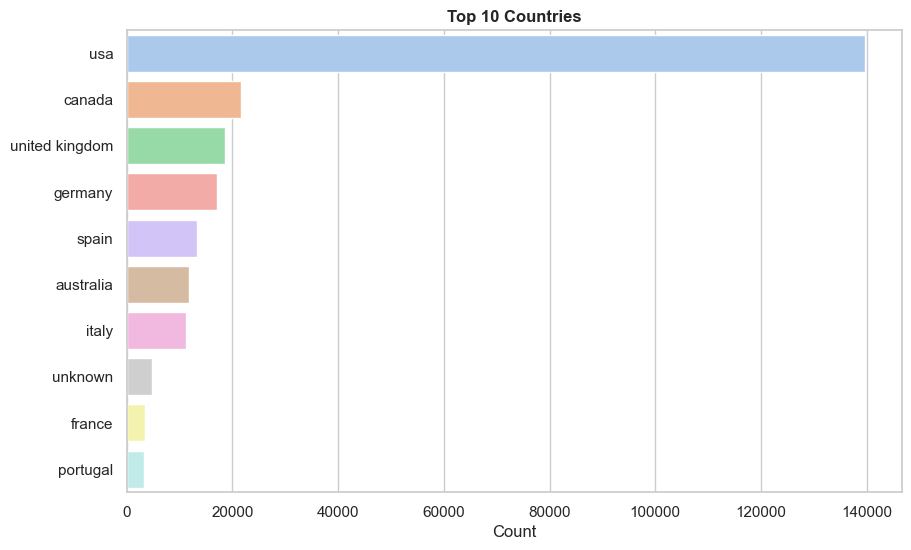

In [73]:
plt.figure(figsize=(10,6))
sns.countplot(y='country_clean', data=users_df,
              order=users_df['country_clean'].value_counts().iloc[:10].index,
              palette='pastel')
plt.title('Top 10 Countries', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

### 3.6.2. City

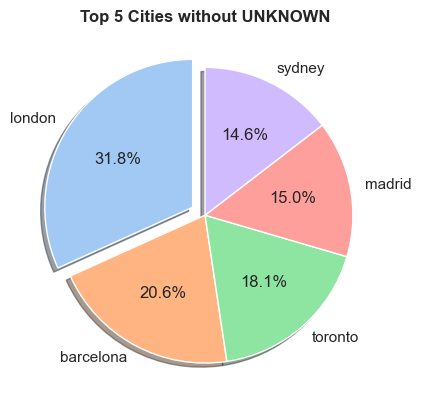

In [74]:
palette_color = sns.color_palette('pastel')
explode = [0.1] + [0]*(min(5, len(users_df['city_clean'].value_counts())) - 1)  # highlight first slice

users_df['city_clean'].value_counts().iloc[1:6].plot(
    kind='pie',
    colors=palette_color,
    autopct='%.1f%%',
    explode=explode,
    shadow=True,
    startangle=90
)
plt.title('Top 5 Cities without UNKNOWN', fontweight='bold')
plt.ylabel('')
plt.show()

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\387353821.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='city_clean', data=users_df,


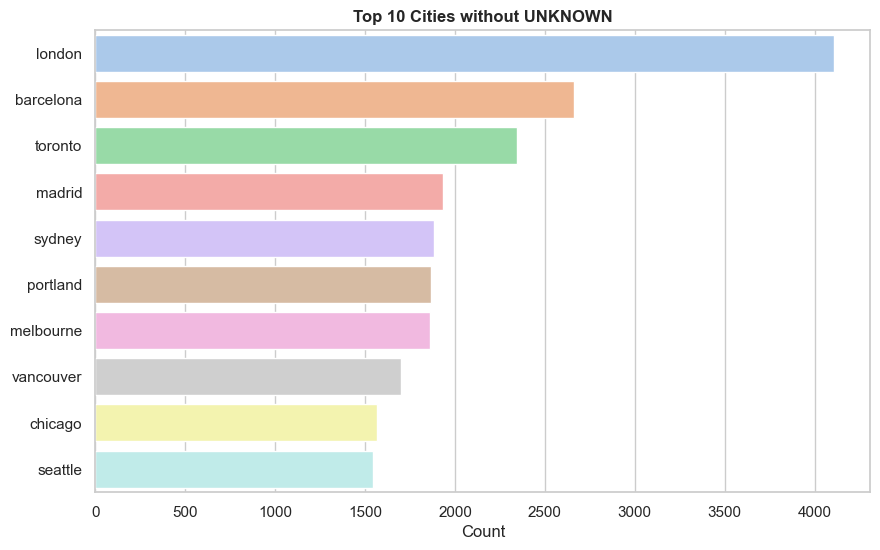

In [75]:
plt.figure(figsize=(10,6))
sns.countplot(y='city_clean', data=users_df,
              order=users_df['city_clean'].value_counts().iloc[1:11].index,
              palette='pastel')
plt.title('Top 10 Cities without UNKNOWN', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\2677712999.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='city_clean', data=users_df,


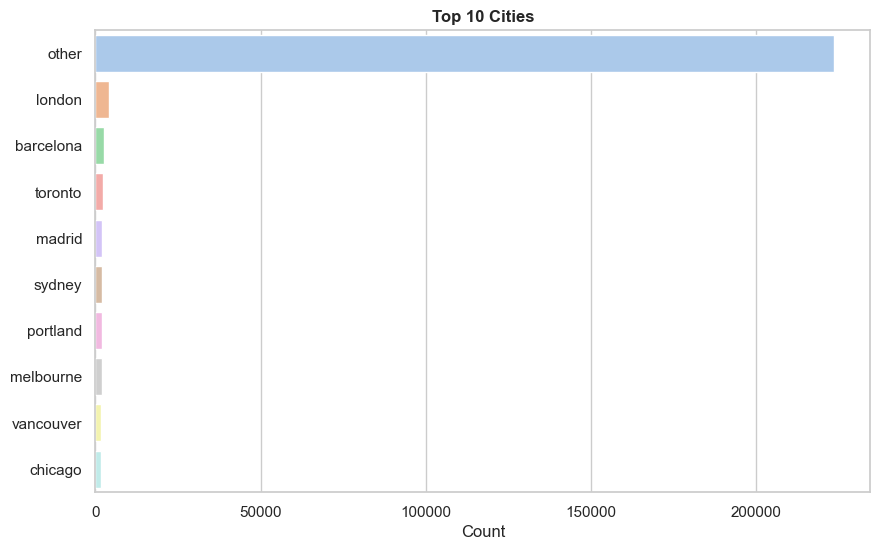

In [76]:
plt.figure(figsize=(10,6))
sns.countplot(y='city_clean', data=users_df,
              order=users_df['city_clean'].value_counts().iloc[:10].index,
              palette='pastel')
plt.title('Top 10 Cities', fontweight='bold')
plt.xlabel('Count')
plt.ylabel('')
plt.show()

In [77]:
ratings_df.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


# RESI OVU FUNKCIJU

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette=palette)


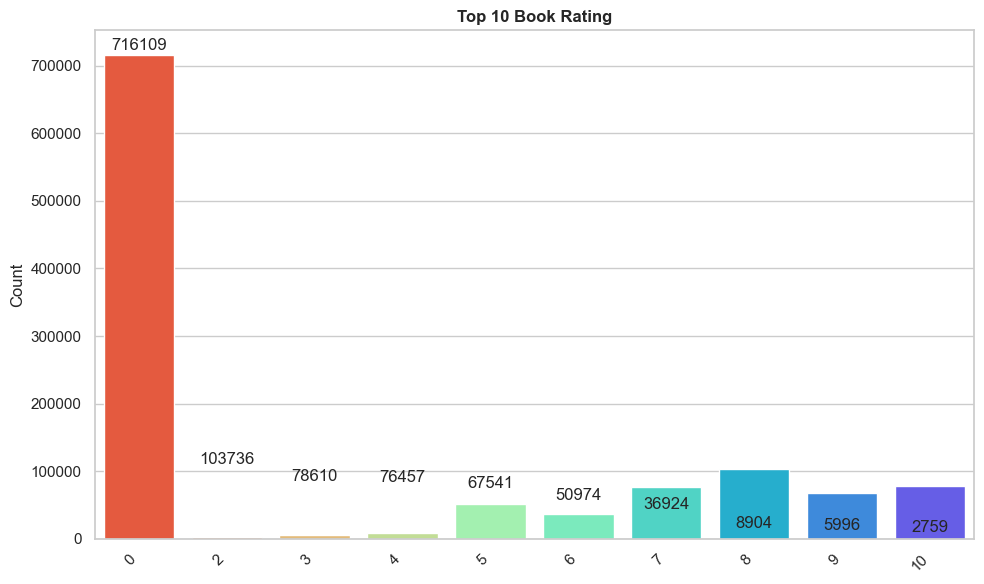

In [78]:
plot_top_categories(ratings_df, 'book_rating', top_n=10, orientation='v', palette='rainbow_r')

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=palette)


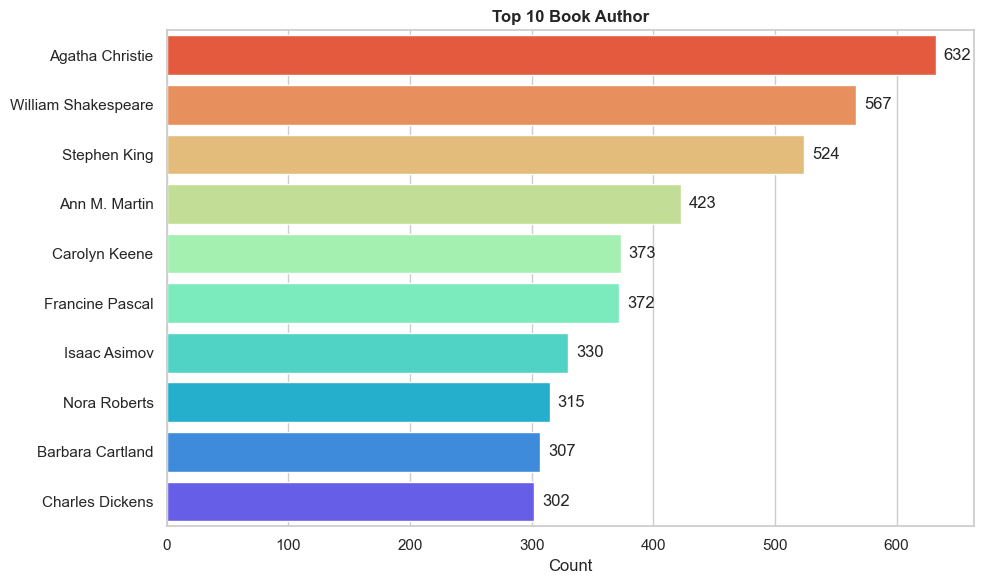

In [79]:
plot_top_categories(books_df, 'book_author', top_n=10, orientation='h', palette='rainbow_r')

In [80]:
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.values, y=counts.index, palette=palette)


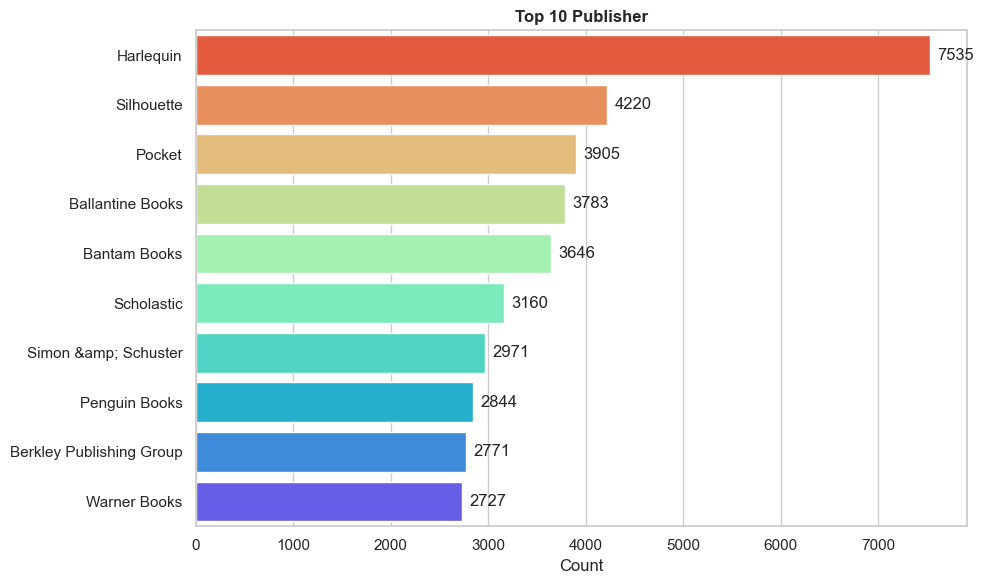

In [81]:
plot_top_categories(books_df, 'publisher', top_n=10, orientation='h', palette='rainbow_r')

# 4. Data Preparation

# Removing INVALID isbn-s

### Books dataframe

In [82]:
# Find invalid isbns (not 10 or 13 characters long), too long or too short
# contains letters other than X, are missing
#invalid_isbn_mask = ~books_df['isbn'].astype(str).str.match(r'^\d{9}[\dXx]$|^\d{13}$')

#invalid_isbn = books_df.loc[invalid_isbn_mask, ['isbn', 'book_title', 'book_author', 'publisher']]
#invalid_isbn

In [83]:
#books_df['isbn'] = books_df['isbn'].str.replace('-', '').str.strip()
#books_df.loc[~books_df['isbn'].astype(str).str.match(r'^\d{9}[\dXx]$|^\d{13}$'), 'isbn'] = np.nan

### Ratings Dataframe

In [84]:
#invalid_isbn_mask_ratings = ~ratings_df['isbn'].astype(str).str.match(r'^\d{9}[\dXx]$|^\d{13}$')
#invalid_isbn_ratings = ratings_df.loc[invalid_isbn_mask_ratings, ['user_id', 'isbn', 'book_rating',]]
#invalid_isbn_ratings

In [85]:
#ratings_df['isbn'] = ratings_df['isbn'].astype(str).str.replace(r'\.0$', '', regex=True).str.strip()
#ratings_df.loc[~ratings_df['isbn'].str.match(r'^\d{9}[\dXx]$|^\d{13}$'), 'isbn'] = np.nan

# 4.1. Data Cleaning

In [86]:
books_df.head()

,isbn,book_title,book_author,year_of_publication,publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


### 4.1.1. Removing Outliers

### 4.1.1.1. USERS DATAFRAME

In [87]:
# Explicitly remove impossible ages
users_df.loc[(users_df['age'] <= 5) | (users_df['age'] > 99), 'age'] = np.nan

lower_bound = Q1 - 1.5*IQR = 24 - 30 = -6, leaves a lot of ages 0
upper_bound = Q3 + 1.5*IQR = 44 + 30 = 74, too low

In [88]:
#Q1 = users_df['age'].quantile(0.25)
#Q3 = users_df['age'].quantile(0.75)
#IQR = Q3 - Q1

# Replace extreme outliers with NaN
#users_df.loc[(users_df['age'] < Q1 - 1.5*IQR) | (users_df['age'] > Q3 + 1.5*IQR), 'age'] = np.nan

c:\Users\Milos\Desktop\ESCAPE_9-5\PYTHON\GitHub_Kaggle_Projects\what-else-should-I-read\src\plots.py:81: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(y=column, data=df, palette=palette)


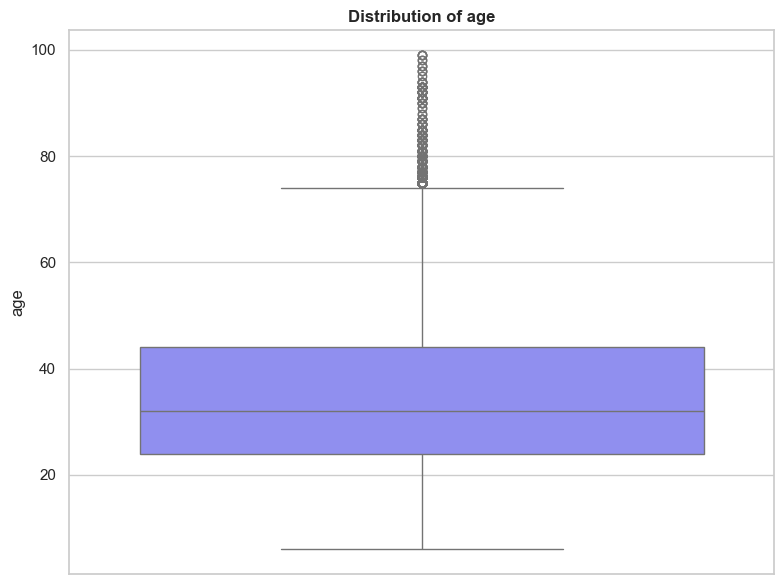

<Axes: title={'center': 'Distribution of age'}, ylabel='age'>

In [89]:
plot_boxplot(users_df, 'age', title='Distribution of age', ylabel='age', palette='cool')

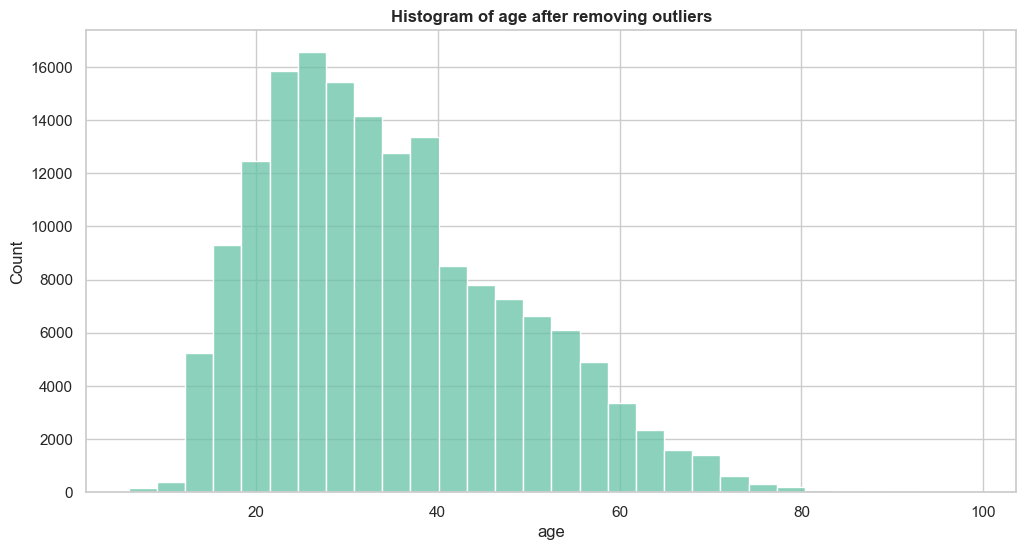

In [90]:
plot_histogram(users_df,"age",bins = 30, title= "Histogram of age after removing outliers")

# 4.1.2. Imputing NaN Values

### 4.1.2.1. USERS DATAFRAME

In [91]:
median = users_df['age'].median()
std = users_df['age'].std()
nulls = users_df['age'].isna().sum()

In [92]:
# Generate random ages from a normal distribution
random_age = np.random.normal(loc=median, scale=std, size=nulls)
random_age = np.clip(random_age, 5, 100)  # limit to plausible range

In [93]:
# Fill NaN with these random ages
users_df.loc[users_df['age'].isna(), 'age'] = random_age.round().astype(int)

In [94]:
get_missing_value_summary(users_df)

,Column,Dtype,TotalValues,MissingValues,NonMissingValues,MissingPercent
0,user_id,int64,278858,0,278858,0.0
1,age,float64,278858,0,278858,0.0
2,country_clean,object,278858,0,278858,0.0
3,region,object,278858,0,278858,0.0
4,city_clean,object,278858,0,278858,0.0
5,state_clean,object,278858,0,278858,0.0


#### 4.1.2.2. BOOKS DATAFRAME

In [95]:
get_missing_value_summary(books_df)

,Column,Dtype,TotalValues,MissingValues,NonMissingValues,MissingPercent
0,isbn,object,271360,0,271360,0.000000
1,book_title,object,271360,0,271360,0.000000
2,book_author,object,271360,2,271358,0.000737
3,year_of_publication,object,271360,0,271360,0.000000
4,publisher,object,271360,2,271358,0.000737


In [96]:
ratings_df.isna().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

In [97]:
books_df[books_df["publisher"] == "Mundania"]

,isbn,book_title,book_author,year_of_publication,publisher


In [98]:
books_df[books_df["publisher"].str.contains("Mundania", case=False, na=False)]

,isbn,book_title,book_author,year_of_publication,publisher
86893,1594260516,Not Without Anna,Vicki M. Taylor,2004,Mundania Press LLC
224597,1594260133,Single White Psychopath Seeks Same,Jeff Strand,2003,Mundania Press LLC
250688,1594260265,Legacy Of The Black Dragon,Julie D'Arcy,2004,Mundania Press LLC


In [99]:
books_df[books_df["book_title"] == "Tyrant Moon"]

,isbn,book_title,book_author,year_of_publication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN


Google search

In [100]:
books_df.loc[books_df["book_title"]=="Tyrant Moon","publisher"] = "Mundania Press LLC"

In [101]:
books_df[books_df["publisher"].isnull()]

,isbn,book_title,book_author,year_of_publication,publisher
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [102]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            2
year_of_publication    0
publisher              1
dtype: int64

In [103]:
books_df[books_df["publisher"].str.contains("Random House Publishing", case=False, na=False)]

,isbn,book_title,book_author,year_of_publication,publisher
224846,034547001X,Return Engagement,LYNN MICHAELS,2003,Random House Publishing Group
266501,0345470001,Desperate Measures,FERN MICHAELS,2003,Random House Publishing Group


In [104]:
books_df.loc[books_df["book_title"]=="Finders Keepers","publisher"] = "Random House Publishing Group"

In [105]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            2
year_of_publication    0
publisher              0
dtype: int64

In [106]:
books_df[books_df["book_author"].isnull()]

,isbn,book_title,book_author,year_of_publication,publisher
118033,0751352497,A+ Quiz Masters:01 Earth,NaN,1999,Dorling Kindersley
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


In [107]:
books_df.loc[books_df['isbn'] == '0751352497', 'book_author'] = 'Dorling Kindersley Publishing Staff'
books_df.loc[books_df['isbn'] == '9627982032', 'book_author'] = 'Credit Suisse'

In [108]:
books_df.loc[books_df['book_author'].isna(), ['isbn', 'book_title', 'book_author']]

,isbn,book_title,book_author


Some values appear to be string (type is object not int)

In [109]:
books_df["year_of_publication"]

0         2002
1         2001
2         1991
3         1999
4         1999
          ... 
271355    1988
271356    1991
271357    2004
271358    1996
271359    2000
Name: year_of_publication, Length: 271360, dtype: object

In [110]:
books_df["year_of_publication"].apply(type).value_counts()

year_of_publication
<class 'int'>    205824
<class 'str'>     65536
Name: count, dtype: int64

we are seeing 65,000+ strings but only 3 “bad” rows when we check for non-digits. most of those strings look like numbers "1998"
"2003"
"0"

In [111]:
books_df[~books_df["year_of_publication"].apply(lambda x: str(x).isdigit())]

,isbn,book_title,book_author,year_of_publication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


year_of_publication column is a mess: it contains integers, strings (like '2000'), non-year strings (publisher names such as "DK Publishing Inc"), and impossible values (0, 2030, 2050, 1806, 1378, etc.).

In [112]:
books_df["year_of_publication"].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

DK Publishing Inc and Gallimard

In [113]:
books_df[books_df["year_of_publication"] == "Gallimard"]

,isbn,book_title,book_author,year_of_publication,publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


In [114]:
books_df[books_df["year_of_publication"] == "DK Publishing Inc"]

,isbn,book_title,book_author,year_of_publication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


convert the column to numeric using errors='coerce', which turns invalid values into NaN

In [115]:
books_df["year_of_publication"] = pd.to_numeric(books_df["year_of_publication"], errors='coerce')

In [116]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    3
publisher              0
dtype: int64

In [117]:
books_df.loc[(books_df["year_of_publication"] < 1000) | 
             (books_df["year_of_publication"] > 2025), "year_of_publication"] = np.nan

In [118]:
books_df["year_of_publication"].fillna(books_df["year_of_publication"].median(), inplace=True)
books_df["year_of_publication"] = books_df["year_of_publication"].astype(int)

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\44478353.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  books_df["year_of_publication"].fillna(books_df["year_of_publication"].median(), inplace=True)


In [119]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

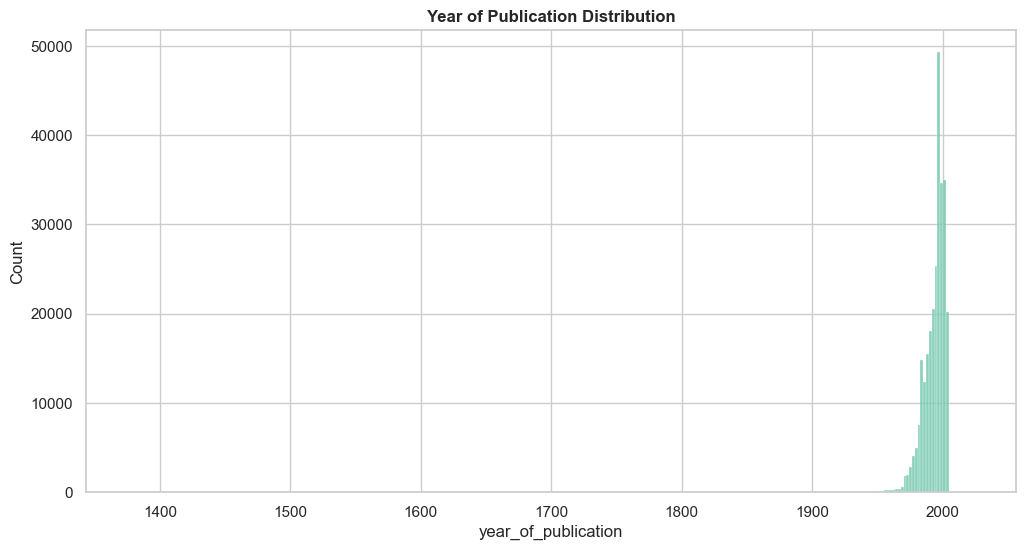

In [120]:
plot_histogram(books_df, 'year_of_publication', bins=300, title='Year of Publication Distribution')

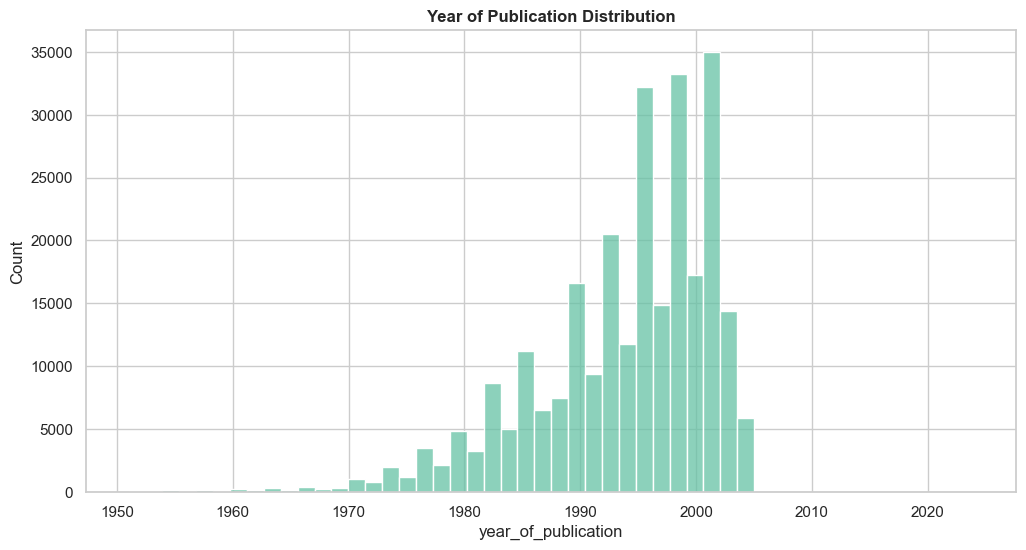

In [121]:
plot_histogram(books_df[books_df["year_of_publication"]>1950], 'year_of_publication', bins=50, title='Year of Publication Distribution')

In [122]:
books_df = books_df[books_df['year_of_publication'].between(1900, 2025)]

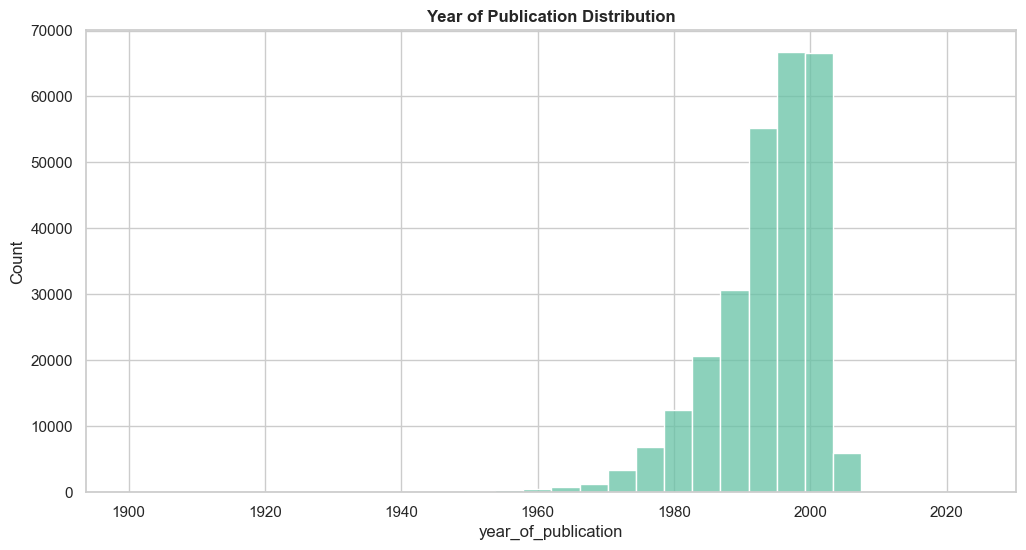

In [123]:
plot_histogram(books_df, 'year_of_publication', bins=30, title='Year of Publication Distribution')

In [124]:
books_df["year_of_publication"].value_counts()

year_of_publication
1996    18663
2002    17627
1999    17431
2001    17359
2000    17232
        ...  
2012        1
2021        1
2008        1
1919        1
2024        1
Name: count, Length: 106, dtype: int64

In [125]:
year_counts = books_df["year_of_publication"].value_counts().sort_index()
year_counts = year_counts.reset_index()
year_counts.columns = ["Year", "Count"]
display(year_counts)

,Year,Count
0,1900,3
1,1901,7
2,1902,2
3,1904,1
4,1906,1
...,...,...
101,2011,2
102,2012,1
103,2020,3
104,2021,1


In [126]:
#from IPython.display import display, HTML

#display(HTML(year_counts.to_html()))

In [127]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

In [128]:
#books_df['image_url_l'].fillna(books_df['image_url_m'], inplace=True)

In [129]:
books_df.isna().sum()

isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

In [130]:
users_df.isna().sum()

user_id          0
age              0
country_clean    0
region           0
city_clean       0
state_clean      0
dtype: int64

In [131]:
ratings_df.isna().sum()

user_id        0
isbn           0
book_rating    0
dtype: int64

#### 4.1.2.3. RATINGS DATAFRAME

In [132]:
ratings_df.head()

,user_id,isbn,book_rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [133]:
ratings_df["book_rating"].apply(type).value_counts()

book_rating
<class 'int'>    1149780
Name: count, dtype: int64

In [134]:
ratings_df["isbn"].apply(type).value_counts()

isbn
<class 'str'>    1149780
Name: count, dtype: int64

In [135]:
ratings_df["user_id"].apply(type).value_counts()

user_id
<class 'int'>    1149780
Name: count, dtype: int64

# 4.2. Feature Engineering

In [136]:
books_df['isbn'].duplicated().sum()

np.int64(0)

In [137]:
users_df['user_id'].duplicated().sum()

np.int64(0)

In [138]:
books_df["isbn"].apply(type).value_counts()

isbn
<class 'str'>    271356
Name: count, dtype: int64

In [139]:
books_df["book_title"].apply(type).value_counts()

book_title
<class 'str'>    271356
Name: count, dtype: int64

In [140]:
books_df["book_author"].apply(type).value_counts()

book_author
<class 'str'>    271356
Name: count, dtype: int64

In [141]:
books_df["publisher"].apply(type).value_counts()

publisher
<class 'str'>    271356
Name: count, dtype: int64

In [142]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271356 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271356 non-null  object
 1   book_title           271356 non-null  object
 2   book_author          271356 non-null  object
 3   year_of_publication  271356 non-null  int64 
 4   publisher            271356 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.4+ MB


In [143]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   user_id        278858 non-null  int64  
 1   age            278858 non-null  float64
 2   country_clean  278858 non-null  object 
 3   region         278858 non-null  object 
 4   city_clean     278858 non-null  object 
 5   state_clean    278858 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 12.8+ MB


In [144]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149780 non-null  int64 
 1   isbn         1149780 non-null  object
 2   book_rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [145]:
ratings_df['isbn'] = ratings_df['isbn'].astype(str)
books_df['isbn'] = books_df['isbn'].astype(str)

ratings_df['user_id'] = ratings_df['user_id'].astype(int)
users_df['user_id'] = users_df['user_id'].astype(int)

In [146]:
books_df['book_title'] = books_df['book_title'].astype(str)

In [147]:
books_df['book_author'] = books_df['book_author'].astype(str)

In [148]:
books_df['publisher'] = books_df['publisher'].astype(str)

In [149]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271356 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   isbn                 271356 non-null  object
 1   book_title           271356 non-null  object
 2   book_author          271356 non-null  object
 3   year_of_publication  271356 non-null  int64 
 4   publisher            271356 non-null  object
dtypes: int64(1), object(4)
memory usage: 12.4+ MB


# Merge Ratings Users

In [150]:
users_df.shape

(278858, 6)

In [151]:
ratings_df.shape

(1149780, 3)

In [152]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   user_id      1149780 non-null  int64 
 1   isbn         1149780 non-null  object
 2   book_rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [153]:
users_ratings=pd.merge(users_df,ratings_df,on='user_id') # merging df_users with df_ratings based on user_id

In [154]:
users_ratings.shape

(1149780, 8)

In [155]:
users_ratings.head()

,user_id,age,country_clean,region,city_clean,state_clean,isbn,book_rating
0,2,18.0,usa,North America,other,california,0195153448,0
1,7,39.0,usa,North America,washington,other,034542252,0
2,8,31.0,canada,North America,other,ontario,0002005018,5
3,8,31.0,canada,North America,other,ontario,0060973129,0
4,8,31.0,canada,North America,other,ontario,0374157065,0


Always merge and join datasets on isbn, not book_title.

Why:

isbn uniquely identifies the specific item across all tables.

book_title may not be unique (multiple editions, typos, or differences in casing).

Using book_title for merging will cause duplicates, mismatched joins, or missing records.

In [156]:
merged_df=pd.merge(users_ratings,books_df,on='isbn') # merging  merged_df with df_books based on isbn

In [157]:
original_merged_df = merged_df

In [158]:
merged_df.shape

(1031132, 12)

In [159]:
merged_df.head()

,user_id,age,country_clean,region,city_clean,state_clean,isbn,book_rating,book_title,book_author,year_of_publication,publisher
0,2,18.0,usa,North America,other,california,0195153448,0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,8,31.0,canada,North America,other,ontario,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,8,31.0,canada,North America,other,ontario,0060973129,0,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,8,31.0,canada,North America,other,ontario,0374157065,0,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,8,31.0,canada,North America,other,ontario,0393045218,0,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [160]:
merged_df.isna().sum()

user_id                0
age                    0
country_clean          0
region                 0
city_clean             0
state_clean            0
isbn                   0
book_rating            0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

In [161]:
merged_df.isnull().sum()

user_id                0
age                    0
country_clean          0
region                 0
city_clean             0
state_clean            0
isbn                   0
book_rating            0
book_title             0
book_author            0
year_of_publication    0
publisher              0
dtype: int64

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\4056676647.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


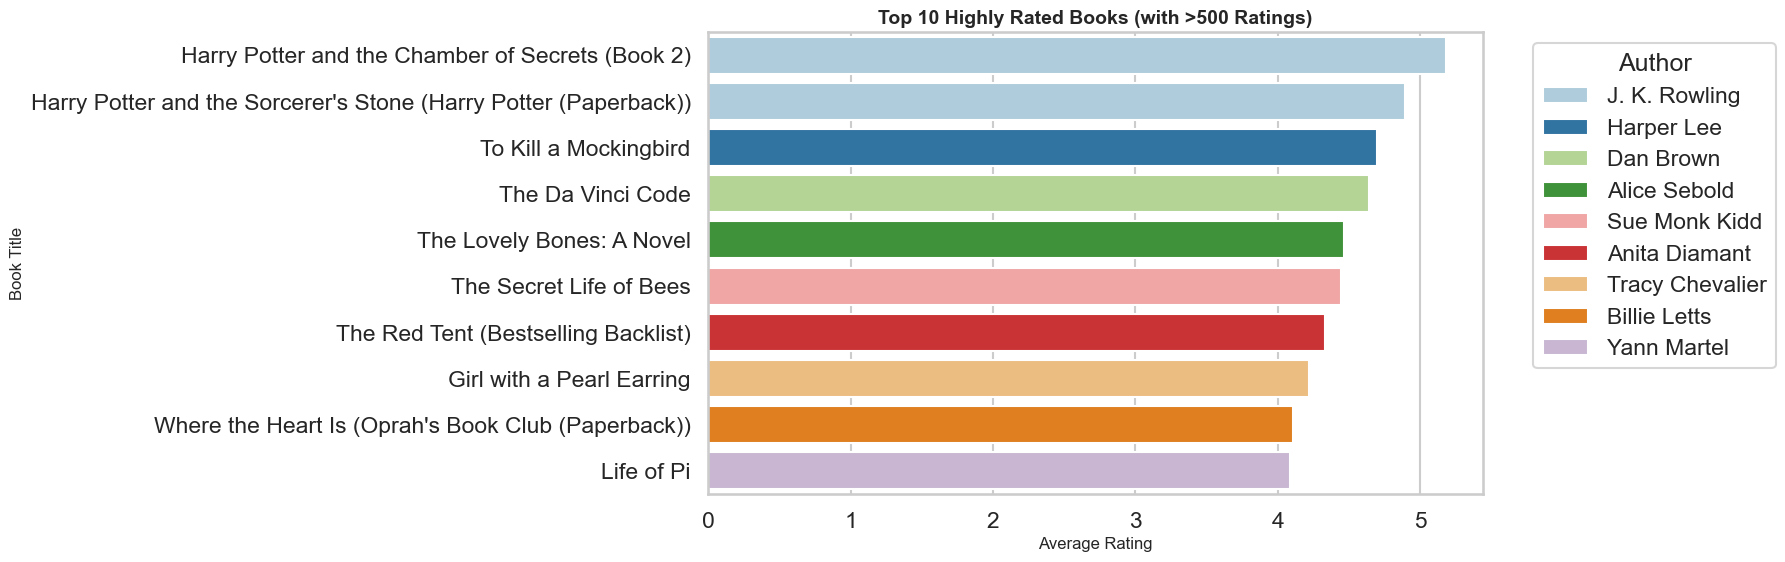

In [162]:
# Aggregate mean and count of ratings per book
book_rating = (
    merged_df.groupby(['book_title', 'book_author'])['book_rating']
    .agg(count='count', mean='mean')
    .reset_index()
)

# Filter to only books with a substantial number of ratings
filtered_books = book_rating.query("count > 500").sort_values('mean', ascending=False).head(10)

# Improve the plot
sns.set(style="whitegrid", context="talk")
plt.figure(figsize=(10, 6))
sns.barplot(
    data=filtered_books,
    x='mean',
    y='book_title',
    hue='book_author',
    palette='Paired',
)

# Labels and title
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Book Title', fontsize=12)
plt.title('Top 10 Highly Rated Books (with >500 Ratings)', fontsize=14, fontweight='bold')
plt.legend(title='Author', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [163]:
merged_df["book_rating"].value_counts()

book_rating
0     647293
8      91804
10     71224
7      66402
9      60778
5      45354
6      31687
4       7616
3       5118
2       2375
1       1481
Name: count, dtype: int64

# Feature Engineering for Content Based Approach

In [164]:
merged_df = merged_df[merged_df['book_rating']!=0]

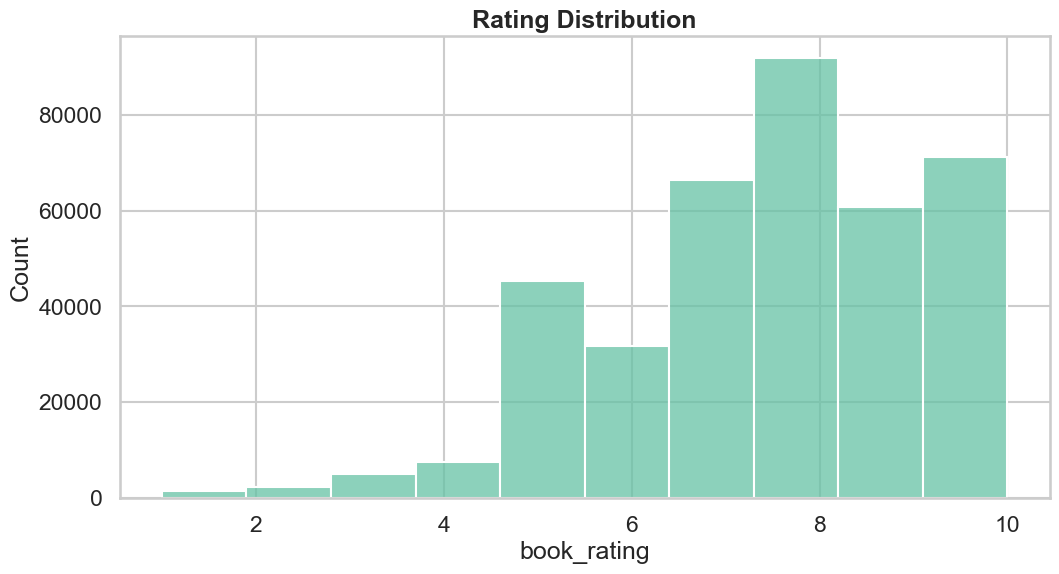

In [165]:
plot_histogram(merged_df, 'book_rating', bins=10, title='Rating Distribution')

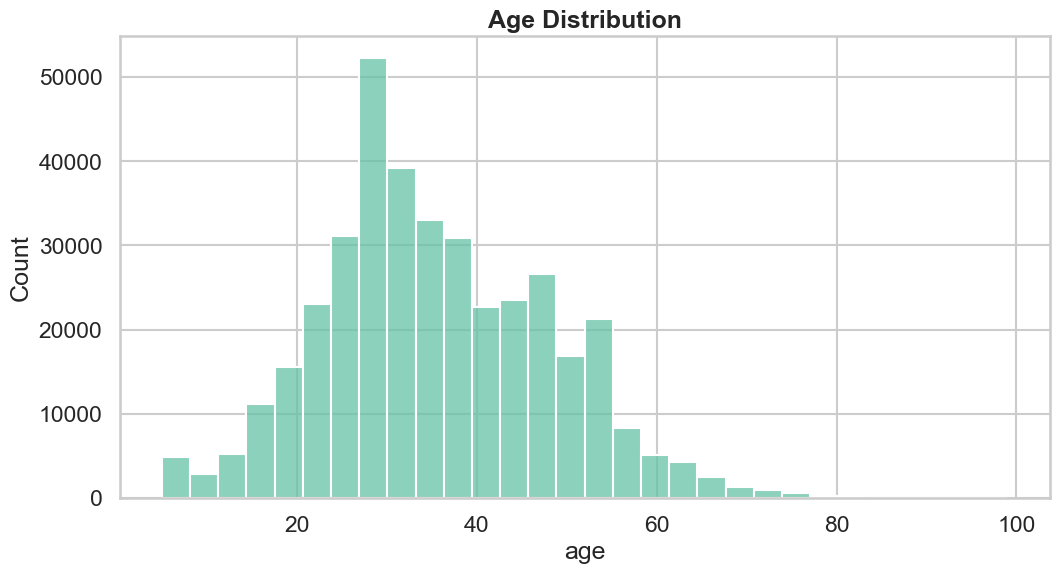

In [166]:
plot_histogram(merged_df, 'age', bins=30, title='Age Distribution')

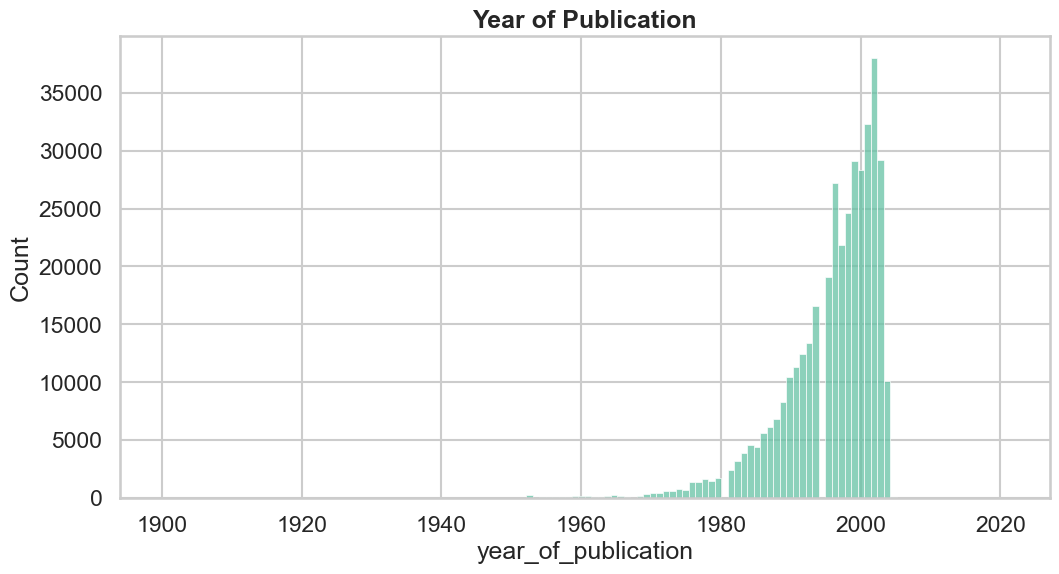

In [167]:
plot_histogram(merged_df, 'year_of_publication', bins=130, title='Year of Publication')

### User Level Features

In [168]:
# --- USER-LEVEL FEATURES ---

# Average rating given by each user
merged_df['user_avg_rating'] = merged_df.groupby('user_id')['book_rating'].transform('mean')

# Total number of ratings by each user
merged_df['user_num_ratings'] = merged_df.groupby('user_id')['book_rating'].transform('count')

# How consistent a user’s ratings are (standard deviation)
merged_df['User_rating_variability'] = merged_df.groupby('user_id')['book_rating'].transform('std')

# Create a separate dataframe for easy inspection
user_level_features = merged_df[['user_id', 'user_avg_rating', 'user_num_ratings', 'User_rating_variability']].drop_duplicates()

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\1783416005.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['user_avg_rating'] = merged_df.groupby('user_id')['book_rating'].transform('mean')
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\1783416005.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['user_num_ratings'] = merged_df.groupby('user_id')['book_rating'].transform('count')
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\1783416005.py:10: SettingWithCopyWarning: 
A value is 

In [169]:
# --- USER age GROUP FEATURE ---

# Define bins (adjustable) and labels 1–5
age_bins = [0, 18, 25, 35, 50, 100]  # covers ages up to 120
age_labels = [1, 2, 3, 4, 5]         # numeric group codes

# Create a new column
merged_df['User_age_Group'] = pd.cut(
    merged_df['age'],
    bins=age_bins,
    labels=age_labels,
    right=False  # includes the left edge (e.g., 18 goes to group 2)
).astype(int)

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\600240810.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['User_age_Group'] = pd.cut(


In [170]:
merged_df

,user_id,age,country_clean,region,city_clean,state_clean,isbn,book_rating,book_title,book_author,year_of_publication,publisher,user_avg_rating,user_num_ratings,User_rating_variability,User_age_Group
1,8,31.0,canada,North America,other,ontario,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,5.571429,7,0.786796,3
9,8,31.0,canada,North America,other,ontario,074322678X,5,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,5.571429,7,0.786796,3
12,8,31.0,canada,North America,other,ontario,0887841740,5,The Middle Stories,Sheila Heti,2004,House of Anansi Press,5.571429,7,0.786796,3
13,8,31.0,canada,North America,other,ontario,1552041778,5,Jane Doe,R. J. Kaiser,1999,Mira Books,5.571429,7,0.786796,3
15,8,31.0,canada,North America,other,ontario,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,5.571429,7,0.786796,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031125,278854,30.0,usa,North America,portland,oregon,0375703063,7,A Virtuous Woman (Oprah's Book Club (Paperback)),Kaye Gibbons,1997,Vintage Books,7.000000,6,0.632456,3
1031126,278854,30.0,usa,North America,portland,oregon,042516098X,7,Hornet's Nest,Patricia Daniels Cornwell,1998,Berkley Publishing Group,7.000000,6,0.632456,3
1031127,278854,30.0,usa,North America,portland,oregon,0425163393,7,Kat Scratch Fever (Kat Colorado Mysteries),Karen Kijewski,1998,Berkley Publishing Group,7.000000,6,0.632456,3
1031129,278854,30.0,usa,North America,portland,oregon,0553275739,6,In Her Day,Rita Mae Brown,1988,Bantam Books,7.000000,6,0.632456,3


### Book Level Features

In [171]:
# --- BOOK-LEVEL FEATURES ---

# Average rating per book (some books have multiple isbns)
merged_df['book_avg_rating'] = merged_df.groupby('book_title')['book_rating'].transform('mean')

# Number of ratings per book
merged_df['book_num_ratings'] = merged_df.groupby('book_title')['book_rating'].transform('count')

# Standard deviation of ratings per book (optional but insightful)
merged_df['book_rating_variability'] = merged_df.groupby('book_title')['book_rating'].transform('std')

# Optional: Book popularity score (weighted by number of ratings)
merged_df['book_popularity_score'] = merged_df['book_avg_rating'] * np.log1p(merged_df['book_num_ratings'])

# Create a distinct book-level summary DataFrame
book_level_features = merged_df[['book_title', 'book_avg_rating', 'book_num_ratings', 'book_rating_variability', 'book_popularity_score']].drop_duplicates()

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\1086413388.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['book_avg_rating'] = merged_df.groupby('book_title')['book_rating'].transform('mean')
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\1086413388.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['book_num_ratings'] = merged_df.groupby('book_title')['book_rating'].transform('count')
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\1086413388.py:10: SettingWithCopyWarning: 
A val

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\2506594480.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='book_num_ratings', y='book_title', data=top_books, palette='viridis')


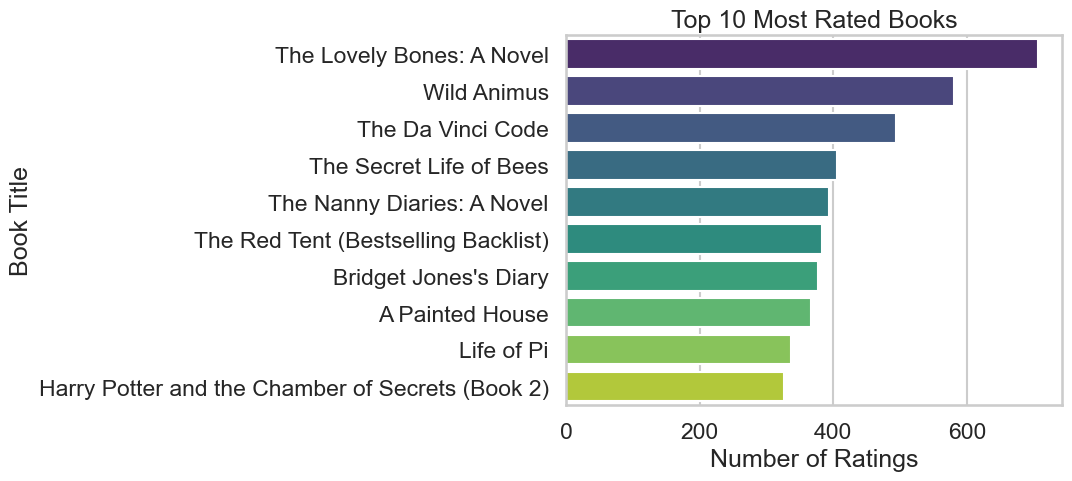

In [172]:
top_books = book_level_features.sort_values('book_num_ratings', ascending=False).head(10)
sns.barplot(x='book_num_ratings', y='book_title', data=top_books, palette='viridis')
plt.title('Top 10 Most Rated Books')
plt.xlabel('Number of Ratings')
plt.ylabel('Book Title')
plt.show()

In [173]:
merged_df.head()

,user_id,age,country_clean,region,city_clean,state_clean,isbn,book_rating,book_title,book_author,year_of_publication,publisher,user_avg_rating,user_num_ratings,User_rating_variability,User_age_Group,book_avg_rating,book_num_ratings,book_rating_variability,book_popularity_score
1,8,31.0,canada,North America,other,ontario,0002005018,5,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,5.571429,7,0.786796,3,7.666667,9,1.414214,17.653152
9,8,31.0,canada,North America,other,ontario,074322678X,5,Where You'll Find Me: And Other Stories,Ann Beattie,2002,Scribner,5.571429,7,0.786796,3,5.000000,1,NaN,3.465736
12,8,31.0,canada,North America,other,ontario,0887841740,5,The Middle Stories,Sheila Heti,2004,House of Anansi Press,5.571429,7,0.786796,3,5.000000,1,NaN,3.465736
13,8,31.0,canada,North America,other,ontario,1552041778,5,Jane Doe,R. J. Kaiser,1999,Mira Books,5.571429,7,0.786796,3,6.500000,2,2.121320,7.140980
15,8,31.0,canada,North America,other,ontario,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,1998,Brilliance Audio - Trade,5.571429,7,0.786796,3,6.000000,1,NaN,4.158883


In [174]:
merged_df.isna().sum()

user_id                        0
age                            0
country_clean                  0
region                         0
city_clean                     0
state_clean                    0
isbn                           0
book_rating                    0
book_title                     0
book_author                    0
year_of_publication            0
publisher                      0
user_avg_rating                0
user_num_ratings               0
User_rating_variability    39223
User_age_Group                 0
book_avg_rating                0
book_num_ratings               0
book_rating_variability    88137
book_popularity_score          0
dtype: int64

In [175]:
merged_df['User_rating_variability'] = merged_df['User_rating_variability'].fillna(0)
merged_df['book_rating_variability'] = merged_df['book_rating_variability'].fillna(0)

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\2186398032.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['User_rating_variability'] = merged_df['User_rating_variability'].fillna(0)
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\2186398032.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['book_rating_variability'] = merged_df['book_rating_variability'].fillna(0)


In [176]:
# --- AUTHOR-LEVEL FEATURE ---
merged_df['author_avg_rating'] = merged_df.groupby('book_author')['book_rating'].transform('mean')

# --- publisher-LEVEL FEATURE ---
merged_df['publisher_avg_rating'] = merged_df.groupby('publisher')['book_rating'].transform('mean')

# --- BOOK age FEATURE ---
# Assuming 'year_of_publication' is numeric and no future years
current_year = 2025
merged_df['book_age'] = current_year - merged_df['year_of_publication']

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\3291807457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['author_avg_rating'] = merged_df.groupby('book_author')['book_rating'].transform('mean')
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\3291807457.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['publisher_avg_rating'] = merged_df.groupby('publisher')['book_rating'].transform('mean')
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\3291807457.py:10: SettingWithCopyWarning: 


In [177]:
merged_df.isna().sum()

user_id                    0
age                        0
country_clean              0
region                     0
city_clean                 0
state_clean                0
isbn                       0
book_rating                0
book_title                 0
book_author                0
year_of_publication        0
publisher                  0
user_avg_rating            0
user_num_ratings           0
User_rating_variability    0
User_age_Group             0
book_avg_rating            0
book_num_ratings           0
book_rating_variability    0
book_popularity_score      0
author_avg_rating          0
publisher_avg_rating       0
book_age                   0
dtype: int64

In [178]:
merged_df.head()

,user_id,age,country_clean,region,city_clean,state_clean,isbn,book_rating,book_title,book_author,...,user_num_ratings,User_rating_variability,User_age_Group,book_avg_rating,book_num_ratings,book_rating_variability,book_popularity_score,author_avg_rating,publisher_avg_rating,book_age
1,8,31.0,canada,North America,other,ontario,0002005018,5,Clara Callan,Richard Bruce Wright,...,7,0.786796,3,7.666667,9,1.414214,17.653152,7.666667,7.434783,24
9,8,31.0,canada,North America,other,ontario,074322678X,5,Where You'll Find Me: And Other Stories,Ann Beattie,...,7,0.786796,3,5.000000,1,0.000000,3.465736,6.047619,7.633279,23
12,8,31.0,canada,North America,other,ontario,0887841740,5,The Middle Stories,Sheila Heti,...,7,0.786796,3,5.000000,1,0.000000,3.465736,5.000000,7.333333,21
13,8,31.0,canada,North America,other,ontario,1552041778,5,Jane Doe,R. J. Kaiser,...,7,0.786796,3,6.500000,2,2.121320,7.140980,6.600000,7.717884,26
15,8,31.0,canada,North America,other,ontario,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,...,7,0.786796,3,6.000000,1,0.000000,4.158883,7.218750,7.142857,27


### location Based Features

In [179]:
# --- location-BASED FEATURES ---

# Country-level average rating
merged_df['country_avg_rating'] = merged_df.groupby('country_clean')['book_rating'].transform('mean')

# region-level average rating (if region exists)
merged_df['region_avg_rating'] = merged_df.groupby('region')['book_rating'].transform('mean')

# City-level average rating (optional, more granular)
merged_df['city_avg_rating'] = merged_df.groupby('city_clean')['book_rating'].transform('mean')

# User’s bias compared to their country's average
merged_df['user_country_rating_bias'] = merged_df['user_avg_rating'] - merged_df['country_avg_rating']

# Average rating for each Book within each Country
merged_df['book_country_avg_rating'] = merged_df.groupby(['book_title', 'country_clean'])['book_rating'].transform('mean')

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\3440094173.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['country_avg_rating'] = merged_df.groupby('country_clean')['book_rating'].transform('mean')
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\3440094173.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['region_avg_rating'] = merged_df.groupby('region')['book_rating'].transform('mean')
C:\Users\Milos\AppData\Local\Temp\ipykernel_812\3440094173.py:10: SettingWithCopyWarning: 
A v

In [180]:
merged_df.head()

,user_id,age,country_clean,region,city_clean,state_clean,isbn,book_rating,book_title,book_author,...,book_rating_variability,book_popularity_score,author_avg_rating,publisher_avg_rating,book_age,country_avg_rating,region_avg_rating,city_avg_rating,user_country_rating_bias,book_country_avg_rating
1,8,31.0,canada,North America,other,ontario,0002005018,5,Clara Callan,Richard Bruce Wright,...,1.414214,17.653152,7.666667,7.434783,24,7.512798,7.657457,7.65032,-1.94137,7.428571
9,8,31.0,canada,North America,other,ontario,074322678X,5,Where You'll Find Me: And Other Stories,Ann Beattie,...,0.000000,3.465736,6.047619,7.633279,23,7.512798,7.657457,7.65032,-1.94137,5.000000
12,8,31.0,canada,North America,other,ontario,0887841740,5,The Middle Stories,Sheila Heti,...,0.000000,3.465736,5.000000,7.333333,21,7.512798,7.657457,7.65032,-1.94137,5.000000
13,8,31.0,canada,North America,other,ontario,1552041778,5,Jane Doe,R. J. Kaiser,...,2.121320,7.140980,6.600000,7.717884,26,7.512798,7.657457,7.65032,-1.94137,5.000000
15,8,31.0,canada,North America,other,ontario,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,...,0.000000,4.158883,7.218750,7.142857,27,7.512798,7.657457,7.65032,-1.94137,6.000000


In [181]:
merged_df.columns

Index(['user_id', 'age', 'country_clean', 'region', 'city_clean',
       'state_clean', 'isbn', 'book_rating', 'book_title', 'book_author',
       'year_of_publication', 'publisher', 'user_avg_rating',
       'user_num_ratings', 'User_rating_variability', 'User_age_Group',
       'book_avg_rating', 'book_num_ratings', 'book_rating_variability',
       'book_popularity_score', 'author_avg_rating', 'publisher_avg_rating',
       'book_age', 'country_avg_rating', 'region_avg_rating',
       'city_avg_rating', 'user_country_rating_bias',
       'book_country_avg_rating'],
      dtype='object')

In [182]:
# # Example for a single top-rated book
# book_name = filtered_books.iloc[0]['book_title']  # top book

# sns.set(style="whitegrid", context="talk")
# plt.figure(figsize=(10, 6))
# sns.scatterplot(
#     data=merged_df[merged_df['book_title'] == book_name],
#     x='age',
#     y='book_rating',
#     alpha=0.6
# )
# sns.regplot(
#     data=merged_df[merged_df['book_title'] == book_name],
#     x='age',
#     y='book_rating',
#     scatter=False,
#     color='red'
# )

# plt.title(f'Age vs Rating for "{book_name}"', fontsize=14, fontweight='bold')
# plt.xlabel('User Age')
# plt.ylabel('Book Rating')
# plt.tight_layout()
# plt.show()

In [183]:
# sns.scatterplot(data=merged_df, x='age', y='user_avg_rating', alpha=0.4)
# sns.regplot(data=merged_df, x='age', y='user_avg_rating', scatter=False, color='red')
# plt.title('User Age vs Average Rating')
# plt.xlabel('Age')
# plt.ylabel('User Average Rating')
# plt.tight_layout()
# plt.show()


In [184]:
# sns.scatterplot(data=merged_df.drop_duplicates('isbn'),
#                 x='book_popularity_score', y='book_avg_rating', alpha=0.5)
# sns.regplot(data=merged_df.drop_duplicates('isbn'),
#             x='book_popularity_score', y='book_avg_rating', scatter=False, color='red')
# plt.title('Book Popularity Score vs Average Rating')
# plt.xlabel('Book Popularity Score')
# plt.ylabel('Average Rating')
# plt.tight_layout()
# plt.show()

In [185]:
# sns.scatterplot(data=merged_df.drop_duplicates('isbn'),
#                 x='book_age', y='book_avg_rating', alpha=0.5)
# sns.regplot(data=merged_df.drop_duplicates('isbn'),
#             x='book_age', y='book_avg_rating', scatter=False, color='red')
# plt.title('Book Age vs Average Rating')
# plt.xlabel('Book Age (years since publication)')
# plt.ylabel('Average Rating')
# plt.tight_layout()
# plt.show()


In [186]:
merged_df["User_age_Group"].value_counts()

User_age_Group
4    131579
3    125861
5     54533
2     47648
1     24218
Name: count, dtype: int64

In [187]:
# # Pivot for heatmap (numeric age groups)
# heatmap_data = (
#     book_age_ratings
#     .pivot(index='book_title', columns='User_age_Group', values='book_rating')
# )

# # Sort rows by one of the numeric columns (e.g., group 1)
# # Make sure the column exists before sorting
# sort_col = 1  # choose any valid numeric group from your data (1–5)
# if sort_col in heatmap_data.columns:
#     heatmap_data = heatmap_data.sort_values(by=sort_col, ascending=False)
# else:
#     # fallback: sort by overall mean if column missing
#     heatmap_data = heatmap_data.assign(mean_rating=heatmap_data.mean(axis=1)) \
#                                .sort_values('mean_rating', ascending=False) \
#                                .drop(columns='mean_rating')

# # Plot heatmap
# plt.figure(figsize=(12, 7))
# sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".2f")

# plt.title('Average Rating by Numeric Age Group and Book', fontsize=14, fontweight='bold')
# plt.xlabel('User Age Group (numeric)')
# plt.ylabel('Book Title')
# plt.tight_layout()
# plt.show()


In [188]:
# # Author vs AgeGroup: mean rating
# author_age = (
#     merged_df.groupby(['book_author', 'User_age_Group'])['book_rating']
#     .mean().reset_index()
# )
# heat = author_age.pivot(index='book_author', columns='User_age_Group', values='book_rating')

# # Optional: limit to top authors by number of ratings
# top_authors = merged_df.groupby('book_author')['book_rating'].count().nlargest(40).index
# heat = heat.reindex(top_authors)

# # sort by group 1 if present, otherwise by row mean
# sort_col = 1
# if sort_col in heat.columns:
#     heat = heat.sort_values(by=sort_col, ascending=False)
# else:
#     heat = heat.assign(_mean=heat.mean(axis=1)).sort_values('_mean', ascending=False).drop(columns=['_mean'])

# plt.figure(figsize=(12,8))
# sns.heatmap(heat, annot=True, fmt=".2f", linewidths=.4, cbar_kws={'label':'Avg rating'})
# plt.title('Author vs User Age Group — Average Rating')
# plt.xlabel('User Age Group')
# plt.ylabel('Author')
# plt.tight_layout()
# plt.show()


In [189]:
# pub_age = (
#     merged_df.groupby(['publisher', 'User_age_Group'])['book_rating']
#     .mean().reset_index()
# )
# heat = pub_age.pivot(index='publisher', columns='User_age_Group', values='book_rating')

# # limit to most prolific publishers
# top_pubs = merged_df.groupby('publisher')['book_rating'].count().nlargest(30).index
# heat = heat.reindex(top_pubs)

# # sort safely
# if 1 in heat.columns:
#     heat = heat.sort_values(by=1, ascending=False)
# else:
#     heat = heat.assign(_mean=heat.mean(axis=1)).sort_values('_mean', ascending=False).drop(columns=['_mean'])

# plt.figure(figsize=(12,8))
# sns.heatmap(heat, annot=True, fmt=".2f", linewidths=.4, cbar_kws={'label':'Avg rating'})
# plt.title('Publisher vs User Age Group — Average Rating')
# plt.xlabel('User Age Group')
# plt.ylabel('Publisher')
# plt.tight_layout()
# plt.show()


In [190]:
merged_df.head()

,user_id,age,country_clean,region,city_clean,state_clean,isbn,book_rating,book_title,book_author,...,book_rating_variability,book_popularity_score,author_avg_rating,publisher_avg_rating,book_age,country_avg_rating,region_avg_rating,city_avg_rating,user_country_rating_bias,book_country_avg_rating
1,8,31.0,canada,North America,other,ontario,0002005018,5,Clara Callan,Richard Bruce Wright,...,1.414214,17.653152,7.666667,7.434783,24,7.512798,7.657457,7.65032,-1.94137,7.428571
9,8,31.0,canada,North America,other,ontario,074322678X,5,Where You'll Find Me: And Other Stories,Ann Beattie,...,0.000000,3.465736,6.047619,7.633279,23,7.512798,7.657457,7.65032,-1.94137,5.000000
12,8,31.0,canada,North America,other,ontario,0887841740,5,The Middle Stories,Sheila Heti,...,0.000000,3.465736,5.000000,7.333333,21,7.512798,7.657457,7.65032,-1.94137,5.000000
13,8,31.0,canada,North America,other,ontario,1552041778,5,Jane Doe,R. J. Kaiser,...,2.121320,7.140980,6.600000,7.717884,26,7.512798,7.657457,7.65032,-1.94137,5.000000
15,8,31.0,canada,North America,other,ontario,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,...,0.000000,4.158883,7.218750,7.142857,27,7.512798,7.657457,7.65032,-1.94137,6.000000


In [191]:
#num_cols = ['age','user_avg_rating','user_num_ratings','User_rating_variability',
  #          'book_avg_rating','book_num_ratings','book_rating_variability',
 #           'book_popularity_score','author_avg_rating','publisher_avg_rating','book_age']
#corr = merged_df[num_cols].corr()

#plt.figure(figsize=(10,8))
#sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=.3)
#plt.title('Correlation Matrix — Numeric Features')
#plt.tight_layout()
#plt.show()


In [192]:
#country_ratings = merged_df.groupby('country_clean')['book_rating'].mean().sort_values(ascending=False).head(15)
#plt.figure(figsize=(12,6))
#sns.barplot(x=country_ratings.values, y=country_ratings.index)
#plt.title('Average Book Rating by Country')
#plt.xlabel('Average Rating')
#plt.ylabel('Country')
#plt.tight_layout()
#plt.show()

In [193]:
#plt.figure(figsize=(8,6))
#sns.scatterplot(data=merged_df.drop_duplicates('isbn'), x='book_age', y='book_avg_rating', alpha=0.5)
#sns.regplot(data=merged_df.drop_duplicates('isbn'), x='book_age', y='book_avg_rating', scatter=False, color='red')
#plt.title('Book Age vs. Average Rating')
#plt.xlabel('Book Age (Years)')
#plt.ylabel('Average Rating')
#plt.tight_layout()
#plt.show()


### Interaction Based Features

In [194]:
merged_df['is_high_rating'] = (merged_df['book_rating'] >= 8).astype(int)

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\2967412507.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['is_high_rating'] = (merged_df['book_rating'] >= 8).astype(int)


In [195]:
# Rank users by number of ratings
merged_df['user_activity_rank'] = merged_df['user_num_ratings'].rank(method='dense', ascending=False)

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\2852668044.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['user_activity_rank'] = merged_df['user_num_ratings'].rank(method='dense', ascending=False)


In [196]:
scale_cols = [
    'age',
    'user_avg_rating', 'user_num_ratings', 'User_rating_variability',
    'book_avg_rating', 'book_num_ratings', 'book_rating_variability', 
    'book_popularity_score', 'book_age',
    'author_avg_rating', 'publisher_avg_rating',
    'country_avg_rating', 'region_avg_rating', 'city_avg_rating',
    'user_country_rating_bias', 'book_country_avg_rating'
]

In [197]:
scaler = MinMaxScaler()
merged_df[scale_cols] = scaler.fit_transform(merged_df[scale_cols])

C:\Users\Milos\AppData\Local\Temp\ipykernel_812\3589566145.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[scale_cols] = scaler.fit_transform(merged_df[scale_cols])


In [198]:
merged_df[scale_cols].describe().T[['min', 'max']]

,min,max
age,0.0,1.0
user_avg_rating,0.0,1.0
user_num_ratings,0.0,1.0
User_rating_variability,0.0,1.0
book_avg_rating,0.0,1.0
book_num_ratings,0.0,1.0
book_rating_variability,0.0,1.0
book_popularity_score,0.0,1.0
book_age,0.0,1.0
author_avg_rating,0.0,1.0


In [199]:
merged_df

,user_id,age,country_clean,region,city_clean,state_clean,isbn,book_rating,book_title,book_author,...,author_avg_rating,publisher_avg_rating,book_age,country_avg_rating,region_avg_rating,city_avg_rating,user_country_rating_bias,book_country_avg_rating,is_high_rating,user_activity_rank
1,8,0.276596,canada,North America,other,ontario,0002005018,5,Clara Callan,Richard Bruce Wright,...,0.740741,0.714976,0.165289,0.689100,0.265979,0.640088,0.415579,0.714286,0,283.0
9,8,0.276596,canada,North America,other,ontario,074322678X,5,Where You'll Find Me: And Other Stories,Ann Beattie,...,0.560847,0.737031,0.157025,0.689100,0.265979,0.640088,0.415579,0.444444,0,283.0
12,8,0.276596,canada,North America,other,ontario,0887841740,5,The Middle Stories,Sheila Heti,...,0.444444,0.703704,0.140496,0.689100,0.265979,0.640088,0.415579,0.444444,0,283.0
13,8,0.276596,canada,North America,other,ontario,1552041778,5,Jane Doe,R. J. Kaiser,...,0.622222,0.746432,0.181818,0.689100,0.265979,0.640088,0.415579,0.444444,0,283.0
15,8,0.276596,canada,North America,other,ontario,1567407781,6,The Witchfinder (Amos Walker Mystery Series),Loren D. Estleman,...,0.690972,0.682540,0.190083,0.689100,0.265979,0.640088,0.415579,0.555556,0,283.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031125,278854,0.265957,usa,North America,portland,oregon,0375703063,7,A Virtuous Woman (Oprah's Book Club (Paperback)),Kaye Gibbons,...,0.702297,0.720129,0.198347,0.709675,0.265979,0.583530,0.521997,0.685990,0,284.0
1031126,278854,0.265957,usa,North America,portland,oregon,042516098X,7,Hornet's Nest,Patricia Daniels Cornwell,...,0.720514,0.715982,0.190083,0.709675,0.265979,0.583530,0.521997,0.605475,0,284.0
1031127,278854,0.265957,usa,North America,portland,oregon,0425163393,7,Kat Scratch Fever (Kat Colorado Mysteries),Karen Kijewski,...,0.669251,0.715982,0.190083,0.709675,0.265979,0.583530,0.521997,0.722222,0,284.0
1031129,278854,0.265957,usa,North America,portland,oregon,0553275739,6,In Her Day,Rita Mae Brown,...,0.723380,0.724535,0.272727,0.709675,0.265979,0.583530,0.521997,0.629630,0,284.0


In [200]:
merged_df.columns

Index(['user_id', 'age', 'country_clean', 'region', 'city_clean',
       'state_clean', 'isbn', 'book_rating', 'book_title', 'book_author',
       'year_of_publication', 'publisher', 'user_avg_rating',
       'user_num_ratings', 'User_rating_variability', 'User_age_Group',
       'book_avg_rating', 'book_num_ratings', 'book_rating_variability',
       'book_popularity_score', 'author_avg_rating', 'publisher_avg_rating',
       'book_age', 'country_avg_rating', 'region_avg_rating',
       'city_avg_rating', 'user_country_rating_bias',
       'book_country_avg_rating', 'is_high_rating', 'user_activity_rank'],
      dtype='object')

# User based personalized recommendation

In [201]:
# Count how many ratings each user has made
users_ratings_count_df = merged_df.groupby('user_id')['book_rating'].count()

print(f'Number of users: {len(users_ratings_count_df):,}')

# Filter users with at least 50 ratings
min_ratings = 50
users_with_enough_ratings_df = users_ratings_count_df[users_ratings_count_df >= min_ratings].reset_index()

print(f'Number of users with at least {min_ratings} ratings: {len(users_with_enough_ratings_df):,}')


Number of users: 68,091
Number of users with at least 50 ratings: 1,180


In [202]:
merged_df.columns

Index(['user_id', 'age', 'country_clean', 'region', 'city_clean',
       'state_clean', 'isbn', 'book_rating', 'book_title', 'book_author',
       'year_of_publication', 'publisher', 'user_avg_rating',
       'user_num_ratings', 'User_rating_variability', 'User_age_Group',
       'book_avg_rating', 'book_num_ratings', 'book_rating_variability',
       'book_popularity_score', 'author_avg_rating', 'publisher_avg_rating',
       'book_age', 'country_avg_rating', 'region_avg_rating',
       'city_avg_rating', 'user_country_rating_bias',
       'book_country_avg_rating', 'is_high_rating', 'user_activity_rank'],
      dtype='object')

# Collaborative Filtering

# 1. User Based  CF - Predict a user’s rating for an item based on ratings from similar users.

for collaborative filtering (CF), you typically just need user-item interactions (like user_id, isbn, and book_rating). Metadata like book titles or user demographics aren’t directly used in standard CF models, though hybrid CF methods can incorporate them.

For collaborative filtering, you only need a few core columns — everything else is feature-engineering data useful for hybrid or content-based models later.

Collaborative filtering (CF) works purely on user–item interactions, not on metadata.
It learns similarity patterns:

users who rated similar books similarly

books rated by similar users

All those other columns (age, country, author_avg_rating, etc.) are side information.
They’re great for:

content-based recommenders,

hybrid models (CF + features),

analytics or fairness analysis,

but not for a pure CF matrix.

FOR CONTENT BASED APPROACH I AM WRITTING HERE SO I DON"T FORGET: one-hot encoding works well for columns with low cardinality, but when you have columns like isbn (149,833 unique values) or book_title (135,564), traditional one-hot encoding becomes impractical because it would create huge, sparse matrices that are both memory- and computation-heavy.

In [203]:
# Step 1: filter active users and reasonably-rated books
min_user_ratings = 50   # Cold Start
min_book_ratings = 20   # safe default; adjust if dataset small

In [204]:
cf_df = merged_df[['user_id', 'book_title', 'book_rating']].copy()

In [205]:
# Compute user and book counts
user_counts = cf_df.groupby('user_id')['book_rating'].count()
book_counts = cf_df.groupby('book_title')['book_rating'].count()

In [206]:
# Select active users and books
active_users = user_counts[user_counts >= min_user_ratings].index
active_books = book_counts[book_counts >= min_book_ratings].index

In [207]:
# Filter dataframe
cf_df_filtered = cf_df[
    cf_df['user_id'].isin(active_users) &
    cf_df['book_title'].isin(active_books)
].copy()

print("Filtered data:", cf_df_filtered['user_id'].nunique(), "users,", 
      cf_df_filtered['book_title'].nunique(), "books,", len(cf_df_filtered), "rows")

Filtered data: 1171 users, 2337 books, 36170 rows


Step 2: create a per-user train / test split so the model evaluation is realistic. Ensure every user appears in the train set (so we can learn their preferences) and also appears in test (so we can evaluate recommendations). Make the split reproducible. 

In [208]:
import numpy as np
from sklearn.model_selection import train_test_split

# Parameters
test_frac = 0.2
random_seed = 42
rng = np.random.RandomState(random_seed)

train_idxs = []
test_idxs = []

# group by user and split each user’s ratings
for user, group in cf_df_filtered.groupby('user_id'):
    idxs = group.index.tolist()
    rng.shuffle(idxs)
    
    n_test = max(1, int(round(test_frac * len(idxs))))
    test_for_user = idxs[:n_test]
    train_for_user = idxs[n_test:]
    
    # ensure user appears in train too
    if len(train_for_user) == 0 and len(test_for_user) > 1:
        train_for_user.append(test_for_user.pop())
    
    train_idxs.extend(train_for_user)
    test_idxs.extend(test_for_user)

# Create splits
train_df = cf_df_filtered.loc[train_idxs].reset_index(drop=True)
test_df = cf_df_filtered.loc[test_idxs].reset_index(drop=True)

print("Train rows:", len(train_df))
print("Test rows :", len(test_df))
print("Unique users in train:", train_df['user_id'].nunique())
print("Unique users in test :", test_df['user_id'].nunique())

Train rows: 28919
Test rows : 7251
Unique users in train: 1151
Unique users in test : 1171


In [209]:
# 1) Identify items in train & test
train_items = set(train_df['book_title'].unique())
test_items  = set(test_df['book_title'].unique())

# 2) Find items that are in test but not in train
unseen_in_train = test_items - train_items
len(unseen_in_train), list(unseen_in_train)[:10]

(4,
 ['Russendisko.',
  "Anil's Ghost (Vintage International)",
  'Io Non Ho Paura',
  'MÃ?Â¶rder ohne Gesicht.'])

In [210]:
# 3) Move one example of each unseen item from test_df -> train_df
moved_count = 0
rows_to_move = []

for item in unseen_in_train:
    # find indices of rows in test_df with this item
    idxs = test_df.index[test_df['book_title'] == item].tolist()
    if not idxs:
        continue
    # pick one index to move (we choose the first)
    pick = idxs[0]
    rows_to_move.append(pick)

# move rows
if rows_to_move:
    rows_to_move = sorted(rows_to_move)  # sort indices for safe removal
    # append those rows to train_df
    rows_to_move_df = test_df.loc[rows_to_move].copy()
    train_df = pd.concat([train_df, rows_to_move_df], ignore_index=True)
    # drop them from test_df
    test_df = test_df.drop(index=rows_to_move).reset_index(drop=True)
    train_df = train_df.reset_index(drop=True)
    moved_count = len(rows_to_move)

print(f"Moved {moved_count} rows from test -> train so every test item exists in train.")
print("New sizes -> Train rows:", len(train_df), "Test rows:", len(test_df))


Moved 4 rows from test -> train so every test item exists in train.
New sizes -> Train rows: 28923 Test rows: 7247


In [211]:
# Users
train_users = set(train_df['user_id'])
test_users  = set(test_df['user_id'])
unseen_users = test_users - train_users
print(f"Unseen users in test: {len(unseen_users)}")

# Items
train_items = set(train_df['book_title'])
test_items  = set(test_df['book_title'])
unseen_items = test_items - train_items
print(f"Unseen items in test: {len(unseen_items)}")

Unseen users in test: 20
Unseen items in test: 0


In [212]:
# Keep only test rows with users and items seen in train
test_df = test_df[
    test_df['user_id'].isin(train_df['user_id']) &
    test_df['book_title'].isin(train_df['book_title'])
].copy()

In [213]:
from sklearn import preprocessing

# Create label encoders
user_encoder = preprocessing.LabelEncoder()
item_encoder = preprocessing.LabelEncoder()

# Fit on train set users/items
train_df['user_idx'] = user_encoder.fit_transform(train_df['user_id'])
train_df['book_idx'] = item_encoder.fit_transform(train_df['book_title'])

# Apply same mapping to test set
test_df['user_idx'] = user_encoder.transform(test_df['user_id'])
test_df['book_idx'] = item_encoder.transform(test_df['book_title'])

print("Unique users encoded:", train_df['user_idx'].nunique())
print("Unique books encoded:", train_df['book_idx'].nunique())

Unique users encoded: 1151
Unique books encoded: 2337


### Step 3: Build user-item MATRIX

In [214]:
from scipy.sparse import csr_matrix

# Dimensions
num_users = train_df['user_idx'].nunique()
num_items = train_df['book_idx'].nunique()

print(f"Matrix dimensions: {num_users} users x {num_items} books")

# Build sparse matrix
train_matrix = csr_matrix(
    (train_df['book_rating'], 
     (train_df['user_idx'], train_df['book_idx'])),
    shape=(num_users, num_items)
)

Matrix dimensions: 1151 users x 2337 books


In [215]:
# Density = proportion of filled ratings
density = train_matrix.count_nonzero() / (num_users * num_items)
print(f"Matrix density: {density:.4f}")

# Show a small dense sample (for inspection only)
train_dense_sample = train_df.pivot_table(
    index='user_idx', columns='book_idx', values='book_rating'
).fillna(0)
train_dense_sample.head()

Matrix density: 0.0106


book_idx,0,1,2,3,4,5,6,7,8,9,...,2327,2328,2329,2330,2331,2332,2333,2334,2335,2336
user_idx,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# cosine similarity with top-K neighbors.

Intuition of the “vector length”

The length of a user vector is basically the magnitude of their ratings.

A user who gives many high ratings will have a longer vector than a user who gives few or low ratings.

Cosine similarity ignores vector length (magnitude) and only considers the angle:

Users with similar patterns of ratings across books are considered similar, even if one rates consistently higher or lower than the other.

### Step 4: Computer User-User Similarity

In [216]:
from sklearn.metrics.pairwise import cosine_similarity

user_sim_matrix = cosine_similarity(train_matrix)
np.fill_diagonal(user_sim_matrix, 0)  # remove self-similarity

### Step 5: Choose k nearest neighbors

In [217]:
k = 20
top_k_users = np.argsort(-user_sim_matrix, axis=1)[:, :k]

In [218]:
# import numpy as np

# # 1️⃣ Compute user mean
# user_mean = np.true_divide(
#     train_matrix.sum(axis=1),
#     (train_matrix != 0).sum(axis=1),
#     where=(train_matrix != 0).sum(axis=1) != 0
# )

# # 2️⃣ Mean-center ratings
# R_centered = train_matrix - user_mean[:, None]
# R_centered[train_matrix == 0] = 0  # don't affect missing values

# # 3️⃣ Weighted prediction: similarity * centered ratings
# numerator = user_sim_matrix.dot(R_centered)
# denominator = np.abs(user_sim_matrix).sum(axis=1)[:, None]

# preds = user_mean[:, None] + numerator / denominator


In [219]:
# # Compute user mean
# user_mean = np.true_divide(
#     train_matrix.sum(axis=1),
#     (train_matrix != 0).sum(axis=1),
#     where=(train_matrix != 0).sum(axis=1) != 0
# )

# # Mean-center ratings
# R_centered = train_matrix - user_mean[:, None]
# R_centered[train_matrix == 0] = 0  # don't affect missing values

# # Weighted prediction: similarity * centered ratings
# numerator = user_sim_matrix.dot(R_centered)
# denominator = np.abs(user_sim_matrix).sum(axis=1)[:, None]

# preds = user_mean[:, None] + numerator / denominator

### Step 6: Predict

In [220]:
user_mean = np.true_divide(train_matrix.sum(axis=1).A1,
                           (train_matrix != 0).sum(axis=1).A1,
                           where=(train_matrix != 0).sum(axis=1).A1 != 0)

# Option A: Convert to DENSE

In [221]:
# make dense (only if it fits)
R = train_matrix.toarray()
# compute user means safely (avoid divide by zero)
counts = (R != 0).sum(axis=1)
user_mean = np.zeros(R.shape[0], dtype=float)
nonzero = counts > 0
user_mean[nonzero] = R.sum(axis=1)[nonzero] / counts[nonzero]

# mean-center
R_centered = R - user_mean[:, None]
R_centered[R == 0] = 0  # keep missing as zeros

# then predictions (user_sim_matrix assumed dense)
numerator = user_sim_matrix.dot(R_centered)
denom = np.abs(user_sim_matrix).sum(axis=1)[:, None]
preds = user_mean[:, None] + numerator / (denom + 1e-8)   # avoid div0


# Option B: doesn't work

In [222]:
# import numpy as np
# import scipy.sparse as sps

# # assume train_matrix is CSR
# R = train_matrix.tocsr().astype(float)  # ensure CSR and float

# # compute user means (sparse-safe)
# sums = np.array(R.sum(axis=1)).ravel()
# counts = np.diff(R.indptr)   # number of non-zeros per row
# user_mean = np.zeros(R.shape[0], dtype=float)
# nonzero = counts > 0
# user_mean[nonzero] = sums[nonzero] / counts[nonzero]

# # create a centered copy by subtracting user_mean from each row's data
# R_centered = R.copy()
# for u in range(R_centered.shape[0]):
#     start, end = R_centered.indptr[u], R_centered.indptr[u+1]
#     if start < end:
#         R_centered.data[start:end] -= user_mean[u]

# # R_centered is sparse where nonzeros now equal (rating - user_mean)
# # You can now multiply with user similarity (dense) -> result dense
# numerator = user_sim_matrix.dot(R_centered)   # sklearn/np will handle sparse dot
# denom = np.abs(user_sim_matrix).sum(axis=1)[:, None]
# preds = user_mean[:, None] + numerator / (denom + 1e-8)


# Option C:

In [223]:
# # SR: straightforward (user_sim_matrix dot train_matrix) - handles sparse train_matrix
# SR = user_sim_matrix.dot(train_matrix)   # result: dense (num_users x num_items)

# # Sbar: S times the user_mean vector broadcasted across columns:
# # Sbar = user_sim_matrix.dot(user_mean[:, None])  -> results shape (num_users, 1)
# Sbar = user_sim_matrix.dot(user_mean[:, None])   # shape (num_users, 1)

# # numerator = SR - Sbar repeated across items
# numerator = SR - Sbar  # numpy will broadcast Sbar across columns

# # denominator as before
# denom = np.abs(user_sim_matrix).sum(axis=1)[:, None]
# preds = user_mean[:, None] + numerator / (denom + 1e-8)


### Step 7: Evaluate

In [224]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Extract test (u,i,r) triples
y_true = test_df['book_rating'].values
y_pred = [preds[u, i] for u, i in zip(test_df['user_idx'], test_df['book_idx'])]

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")

RMSE: 1.5772


### Step 8: Recommend books

In [225]:
def recommend_books_for_user(user_id, preds, n=5):
    user_ratings = preds[user_id]
    top_items = np.argsort(-user_ratings)[:n]
    return top_items

In [226]:
top_item_indices = recommend_books_for_user(42, preds, n=10)

In [227]:
top_books = item_encoder.inverse_transform(top_item_indices)
print(top_books)

['Harry Potter and the Goblet of Fire (Book 4)'
 'Harry Potter and the Chamber of Secrets (Book 2)'
 'Harry Potter and the Prisoner of Azkaban (Book 3)'
 "Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback))"
 'Harry Potter and the Order of the Phoenix (Book 5)'
 "Harry Potter and the Sorcerer's Stone (Book 1)" 'A Walk to Remember'
 'The Da Vinci Code' 'The Secret Life of Bees' 'To Kill a Mockingbird']


In [228]:
top_item_indices = recommend_books_for_user(442, preds, n=10)

In [229]:
top_books = item_encoder.inverse_transform(top_item_indices)
print(top_books)

['The Secret Life of Bees'
 'Harry Potter and the Chamber of Secrets (Book 2)'
 'To Kill a Mockingbird' 'Harry Potter and the Goblet of Fire (Book 4)'
 '84 Charing Cross Road' "Harry Potter and the Sorcerer's Stone (Book 1)"
 "The Color of Water: A Black Man's Tribute to His White Mother"
 'The Notebook' 'Remember Me'
 'Harry Potter and the Prisoner of Azkaban (Book 3)']


# ITEM- BASED CF

In [239]:
# ---------- Assumptions ----------
# train_matrix: scipy.sparse matrix with shape (n_users, n_items)
# test_df: pandas DataFrame with columns ['user_idx', 'book_idx', 'book_rating']
# user_idx and book_idx are zero-based integer indices aligned with train_matrix
# ---------------------------------

# 1) Build item-item similarity (items x items)
item_sim_matrix = cosine_similarity(train_matrix.T)   # shape: (n_items, n_items)
np.fill_diagonal(item_sim_matrix, 0)


In [240]:
# 2) Precompute top-k neighbors (indices + similarities)
k = 20
top_k_idx = np.argsort(-item_sim_matrix, axis=1)[:, :k]            # (n_items, k)
top_k_sims = np.take_along_axis(item_sim_matrix, top_k_idx, axis=1)  # (n_items, k)


In [241]:
# 3) Item means (over users) safely
# R: items x users (we will keep this orientation for dot-products)
R = train_matrix.T.toarray()   # items x users
counts = (R != 0).sum(axis=1)
item_mean = np.zeros(R.shape[0], dtype=float)
nonzero = counts > 0
item_mean[nonzero] = R.sum(axis=1)[nonzero] / counts[nonzero]


In [242]:
# 4) Mean-center only observed ratings; keep missing as 0
R_centered = R - item_mean[:, None]
R_centered[R == 0] = 0   # missing stays 0

In [243]:
# 5) Predict ratings using only top-k neighbors (vectorized)
# For each item i, neighbors are top_k_idx[i] with sims top_k_sims[i]
n_items, n_users = R.shape
preds = np.zeros((n_items, n_users), dtype=float)

# We'll compute numerator and denom item-by-item (vectorized across users)
for i in range(n_items):
    neigh_idx = top_k_idx[i]       # k neighbors for item i, shape (k,)
    sims = top_k_sims[i]           # shape (k,)
    if np.allclose(sims, 0):
        # no similar neighbors -> fallback to item mean
        preds[i, :] = item_mean[i]
        continue

    # neighbor ratings (k x users)
    neigh_ratings = R_centered[neigh_idx, :]   # shape (k, n_users)

    # weighted sum across neighbors -> numerator (n_users,)
    numerator = sims.dot(neigh_ratings)        # (n_users,)
    denom = np.abs(sims).sum()                 # scalar (sum of |sims| for the k neighbors)

    preds[i, :] = item_mean[i] + numerator / (denom + 1e-8)

# preds is (n_items, n_users). To access predicted rating for (user u, item i): preds[i, u]


In [244]:
# 6) Evaluate RMSE on test set (make sure to index correctly)
y_true = test_df['book_rating'].values
y_pred = [preds[i, u] for u, i in zip(test_df['user_idx'], test_df['book_idx'])]
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse:.4f}")


RMSE: 1.7591


In [245]:
# 7) Get top-5 book recommendations per user (mask already-seen items)
n_recs = 5
train_dense = train_matrix.toarray()   # shape: (n_users, n_items)
# preds_user_items: users x items
preds_ui = preds.T   # shape: (n_users, n_items)


In [246]:
# mask seen: set predictions for items user already rated to -inf so they won't be recommended
mask = (train_dense > 0)
preds_ui_masked = preds_ui.copy()
preds_ui_masked[mask] = -np.inf

# get top-n indices for each user
top_n_idx_per_user = np.argsort(-preds_ui_masked, axis=1)[:, :n_recs]   # (n_users, n_recs)


In [247]:
# Example: for user 0 recommended book indices:
# recommended_books_for_user0 = top_n_idx_per_user[0]

# Build a dict or DataFrame of recommendations if you want
user_ids = np.arange(preds_ui_masked.shape[0])
recommendations = {u: top_n_idx_per_user[u].tolist() for u in user_ids}

# print sample
for u in range(5):
    print(f"User {u}: recommended books {recommendations[u]}")

User 0: recommended books [362, 1964, 2099, 413, 534]
User 1: recommended books [362, 1964, 2099, 413, 534]
User 2: recommended books [362, 1964, 2099, 413, 534]
User 3: recommended books [362, 1964, 2099, 413, 534]
User 4: recommended books [362, 1964, 2099, 413, 534]


In [248]:
def recommend_books_for_userItem_based(user_id, preds, item_encoder, n=5):
    """
    Recommend top-n books for a given user based on predicted ratings.

    Parameters:
    - user_id: int, the index of the user (0-based)
    - preds: np.ndarray, shape (n_items, n_users)
    - item_encoder: fitted sklearn encoder or similar, to decode book indices
    - n: int, number of books to recommend

    Returns:
    - top_books: list of decoded book IDs or titles
    """
    # preds is (n_items, n_users), so take the user column
    user_ratings = preds[:, user_id]   # all items for this user
    top_item_indices = np.argsort(-user_ratings)[:n]
    top_books = item_encoder.inverse_transform(top_item_indices)
    return top_books


In [249]:
# Example: get top 10 books for user 42
top_books = recommend_books_for_userItem_based(42, preds, item_encoder, n=10)
print(top_books)

['Chobits (Chobits)' 'The Power of One'
 'The Ultimate Weight Solution: The 7 Keys to Weight Loss Freedom' 'Crazy'
 'Drums of Autumn' 'The Secret Garden'
 'Northern Lights (His Dark Materials S.)' 'The Day After Tomorrow'
 "Are You There God?  It's Me, Margaret"
 'Mort (Discworld Novels (Paperback))']


Train a Collaborative Filtering Model (SVD)

In [ ]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split as surprise_split

In [ ]:
# Define the rating scale
reader = Reader(rating_scale=(0, 10))

# Convert train and test data to Surprise Dataset objects
train_data = Dataset.load_from_df(train_df[['user_id', 'book_title', 'book_rating']], reader)
test_data_df = test_df[['user_id', 'book_title', 'book_rating']]

In [ ]:
# Build full trainset (Surprise’s internal object)
trainset = train_data.build_full_trainset()

# Initialize SVD model
svd_model = SVD(
    n_factors=50,   # latent dimensions
    lr_all=0.005,   # learning rate
    reg_all=0.02,   # regularization
    random_state=42
)

# Train the model
svd_model.fit(trainset)
print("✅ SVD model trained successfully.")

In [ ]:
# Prepare testset for predictions
testset = [tuple(x) for x in test_data_df.to_numpy()]

# Generate predictions
predictions = svd_model.test(testset)

# Compute RMSE and MAE
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")

In [ ]:
def recommend_books_for_user(model, user_id, n=5):
    # Get all unique books
    all_books = train_df['book_title'].unique()
    # Books already rated by the user
    rated_books = train_df[train_df['user_id'] == user_id]['book_title'].tolist()
    # Predict ratings for unseen books
    preds = []
    for book in all_books:
        if book not in rated_books:
            pred = model.predict(user_id, book)
            preds.append((book, pred.est))
    # Sort by predicted rating
    top_books = sorted(preds, key=lambda x: x[1], reverse=True)[:n]
    return pd.DataFrame(top_books, columns=['Book_Title', 'Predicted_Rating'])

# Example usage
sample_user = train_df['user_id'].iloc[0]
recommend_books_for_user(svd_model, sample_user, n=5)

In [ ]:
# Example usage
sample_user = train_df['user_id'].iloc[74]
recommend_books_for_user(svd_model, sample_user, n=5)

In [ ]:
recs = recommend_books_for_user(model=svd_model, user_id=sample_user, n=10)
recs.plot.barh(x='Book_Title', y='Predicted_Rating', figsize=(8,5), legend=False)


In [ ]:
from surprise import dump

# Save the model to a file
dump.dump('svd_model.pkl', algo=svd_model)
print("✅ Model saved successfully to svd_model.pkl")

In [ ]:
import joblib

joblib.dump(user_encoder, 'user_encoder.pkl')
joblib.dump(item_encoder, 'item_encoder.pkl')
train_df.to_csv('train_data.csv', index=False)

In [ ]:
print(train_df['user_id'].unique()[:10])

# ITEM TO ITEM (BOOK -> SIMILAR BOOK) RECOMMENDER

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

# assume train_df exists and has columns: user_id, book_title, book_rating
# Step A: build book / user indices (deterministic)
unique_books = train_df['book_title'].unique()
unique_users = train_df['user_id'].unique()

book_to_idx = {b:i for i,b in enumerate(unique_books)}
idx_to_book = {i:b for b,i in book_to_idx.items()}

user_to_idx = {u:i for i,u in enumerate(unique_users)}
idx_to_user = {i:u for u,i in user_to_idx.items()}

# Step B: map and build sparse item-user matrix (items as rows, users as cols)
train_df['book_idx'] = train_df['book_title'].map(book_to_idx)
train_df['user_idx'] = train_df['user_id'].map(user_to_idx)

num_items = len(book_to_idx)
num_users = len(user_to_idx)

# item-user matrix: rows=item, cols=user
rows = train_df['book_idx'].to_numpy()
cols = train_df['user_idx'].to_numpy()
data = train_df['book_rating'].to_numpy().astype(float)

item_user_csr = csr_matrix((data, (rows, cols)), shape=(num_items, num_users))
print("item_user_csr shape:", item_user_csr.shape, "nnz:", item_user_csr.nnz)

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import numpy as np

# existing matrix shape
num_items, num_users = item_user_csr.shape
print(f"num_items={num_items}, num_users={num_users}")

# Choose n_components safely:
requested_components = 100
# TruncatedSVD requires n_components <= n_features (n_features == num_users here)
max_allowed = num_users  # you can also choose num_users or num_items, but scikit checks against n_features
n_components = min(requested_components, max_allowed)
if n_components < requested_components:
    print(f"Requested n_components={requested_components} is too large for n_features={num_users}.")
    print(f"Falling back to n_components={n_components} (<= n_features).")

# Fit TruncatedSVD
svd = TruncatedSVD(n_components=n_components, random_state=42)
item_factors = svd.fit_transform(item_user_csr)   # shape (num_items, n_components)
print("item_factors shape:", item_factors.shape)

# Normalize (so cosine ~ dot)
item_factors = normalize(item_factors, axis=1)

# Fit nearest neighbors (cosine)
nn = NearestNeighbors(n_neighbors=20, algorithm='brute', metric='cosine')
nn.fit(item_factors)

# Recommend function (same as before)
def recommend_for_book(book_title, topn=10, exclude_self=True):
    if book_title not in book_to_idx:
        raise ValueError(f"Book not in training set: {book_title!r}")

    bidx = book_to_idx[book_title]
    vec = item_factors[bidx].reshape(1, -1)
    # make sure we don't request more neighbors than exist
    k = min(topn + (1 if exclude_self else 0), item_factors.shape[0])
    dists, idxs = nn.kneighbors(vec, n_neighbors=k)
    idxs = idxs[0]
    dists = dists[0]

    results = []
    for i, dist in zip(idxs, dists):
        if exclude_self and i == bidx:
            continue
        results.append((idx_to_book[i], 1.0 - dist))  # similarity ~ 1 - cosine_distance
        if len(results) >= topn:
            break
    return results

# Quick smoke test
example_book = list(book_to_idx.keys())[0]
print("Example book:", example_book)
print(recommend_for_book(example_book, topn=5))


In [ ]:
# Ensure book_metadata indexed by title
bm = book_metadata.set_index('book_title')

def get_recommendations(book_title, topn=10, exclude_self=True, use_fallback=True):
    """
    Returns a DataFrame with recommended books and metadata.
    """
    # fallback match if exact not found
    if book_title not in book_to_idx:
        if use_fallback:
            print(f"Book '{book_title}' not found in train set — trying fuzzy match...")
            book_title = fuzzy_match_title(book_title)
            if book_title is None:
                raise ValueError("Could not find a close match for the input book.")
            print("Using matched title:", book_title)
        else:
            raise ValueError(f"Book not in training set: {book_title!r}")

    recs = recommend_for_book(book_title, topn=topn, exclude_self=exclude_self)
    rows = []
    for title, score in recs:
        meta = bm.loc[title] if title in bm.index else {}
        rows.append({
            'book_title': title,
            'score': score,
            'author': meta.get('book_author', ''),
            'publisher': meta.get('publisher', ''),
            'year': meta.get('year_of_publication', ''),
            'image': meta.get('image_url_l', '')
        })
    return pd.DataFrame(rows)


In [ ]:
from difflib import get_close_matches

def fuzzy_match_title(query, n=1, cutoff=0.6):
    """
    Return best matching title from book_to_idx keys or None.
    cutoff: 0..1 similarity threshold (higher = stricter)
    """
    candidates = get_close_matches(query, list(book_to_idx.keys()), n=n, cutoff=cutoff)
    return candidates[0] if candidates else None

# quick test
print(fuzzy_match_title("Where the Heart Is Oprah", cutoff=0.5))


In [ ]:
import joblib
# Save
joblib.dump({
    'item_factors': item_factors,
    'book_to_idx': book_to_idx,
    'idx_to_book': idx_to_book,
    'book_metadata': book_metadata
}, 'book_item_model.pkl')

# If you used sklearn NearestNeighbors, save it too
joblib.dump(nn, 'nn_index.pkl')

In [ ]:
from collections import defaultdict

def recall_at_k(k=10):
    # build user's train items (from train_df) and test items (from test_df)
    user_train = train_df.groupby('user_id')['book_title'].apply(list).to_dict()
    user_test  = test_df.groupby('user_id')['book_title'].apply(list).to_dict()
    
    hits = 0
    total = 0
    
    for user, test_items in user_test.items():
        train_items = user_train.get(user, [])
        if len(train_items) == 0:
            continue
        # score candidate items by summing similarity to each train item
        candidate_scores = defaultdict(float)
        for t in train_items:
            if t not in book_to_idx:
                continue
            neighbors = recommend_for_book(t, topn=k*5, exclude_self=True)  # more neighbors to allow aggregation
            for nb_title, score in neighbors:
                candidate_scores[nb_title] += score
        # get top-k candidates
        ranked = [t for t,_ in sorted(candidate_scores.items(), key=lambda x: -x[1])][:k]
        # check if any of the user's test items are in ranked list
        for it in test_items:
            total += 1
            if it in ranked:
                hits += 1
    recall = hits / total if total > 0 else np.nan
    return {'k': k, 'hits': hits, 'total': total, 'recall': recall}

# Example
for k in [5, 10, 20]:
    print(recall_at_k(k))


In [ ]:
book_title = "Where the Heart Is (Oprah's Book Club (Paperback))"
recommendations = recommend_for_book(book_title, topn=5)
for title, score in recommendations:
    print(f"{title:60}  similarity={score:.3f}")

# Content-Based Model